In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

from warnings import simplefilter
simplefilter("ignore")

plt.style.use("seaborn-whitegrid")

plt.rc(
    "figure",
    autolayout = True,
    figsize = (9, 5),
)

plt.rc(
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 16,
    titlepad = 10,
)

plot_params = dict(
    color = "0.75",
    style = ".-",
    markeredgecolor = "0.25",
    markerfacecolor = "0.25",
)

%config InlineBackend.figure_format = 'retina'

# EDA for number of orders forecast

Analyse time series data available, namely the distribution of the orders and the month/weekday/hour dependencies for the target variable.

In [2]:
dtype = {
    'num_orders': 'float64',
}

d1 = pd.read_csv(r'C:\Users\pohlp\Downloads\Neo team hiring home task\taxi.csv', dtype = dtype, index_col = "datetime", parse_dates = ["datetime"])
d1 = d1.sort_index()

d1["Date"] = d1.index.floor(freq='1h')
d1 = d1.groupby("Date").num_orders.sum().to_frame()
d1["Month"] = d1.index.month
d1["Day"] = d1.index.day
d1["Hour"] = d1.index.hour
d1["weekday"] = d1.index.weekday

d1.head()

num_orders  Month  Day  Hour  weekday
Date                                                      
2018-01-03 00:00:00       124.0      1    3     0        2
2018-01-03 01:00:00        85.0      1    3     1        2
2018-01-03 02:00:00        71.0      1    3     2        2
2018-01-03 03:00:00        66.0      1    3     3        2
2018-01-03 04:00:00        43.0      1    3     4        2

Sizable amount of missing values in the dataset. March to August the data is nearly complete, but the other half of the year has more than 70% of its data missing.

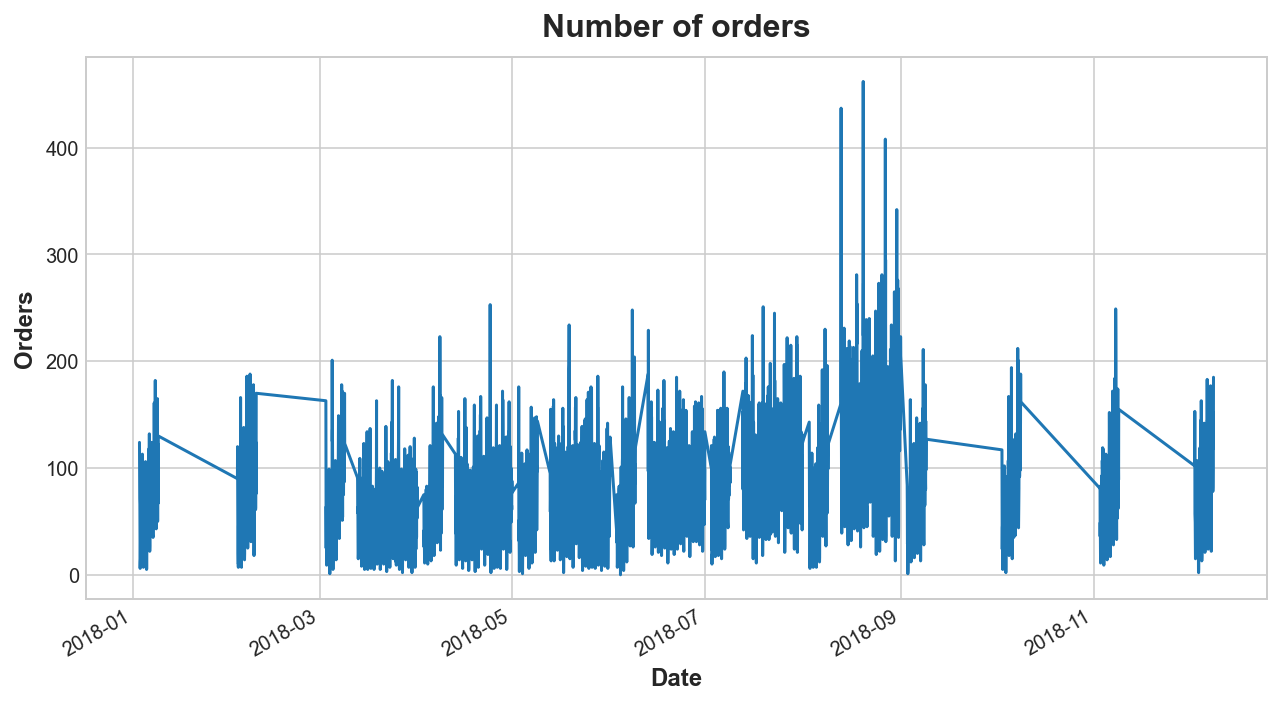

In [3]:
d1.num_orders.plot(title = "Number of orders", ylabel = "Orders");

Right-skewed near-normal distribution for the orders data.

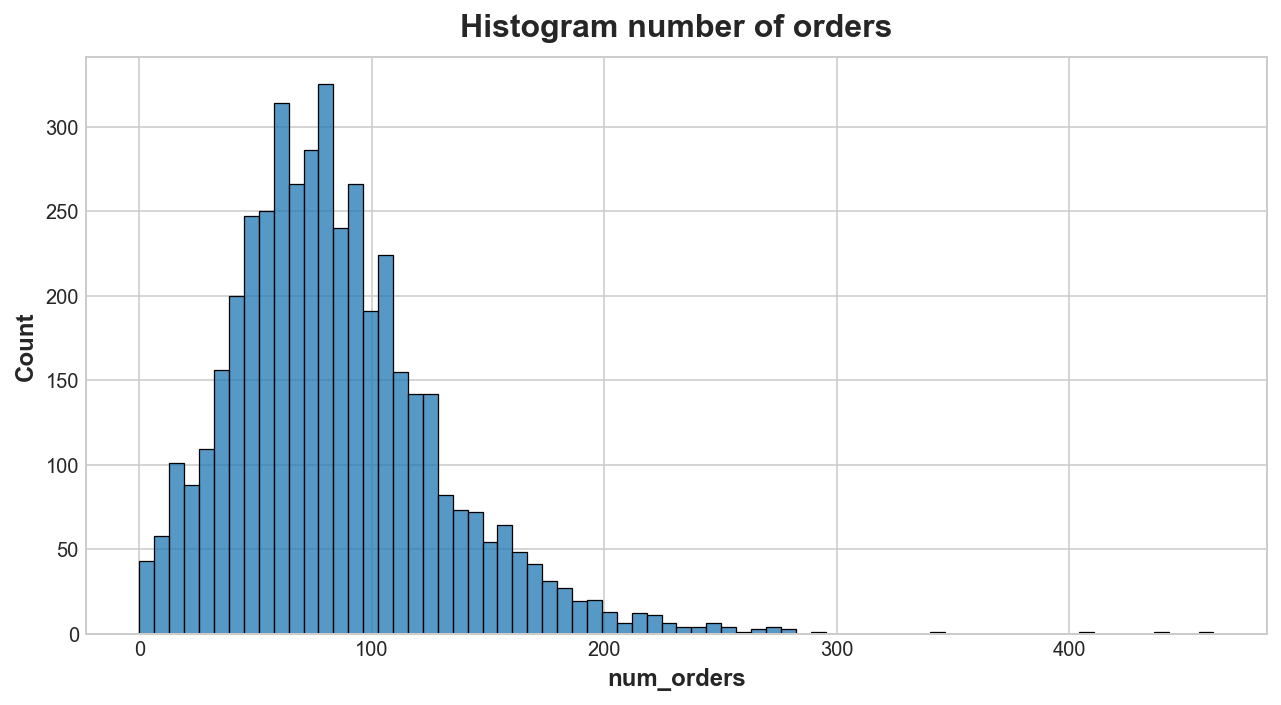

In [4]:
sns.histplot(data = d1.num_orders)
plt.title("Histogram number of orders");

Sizable number of outliers in our dataset.

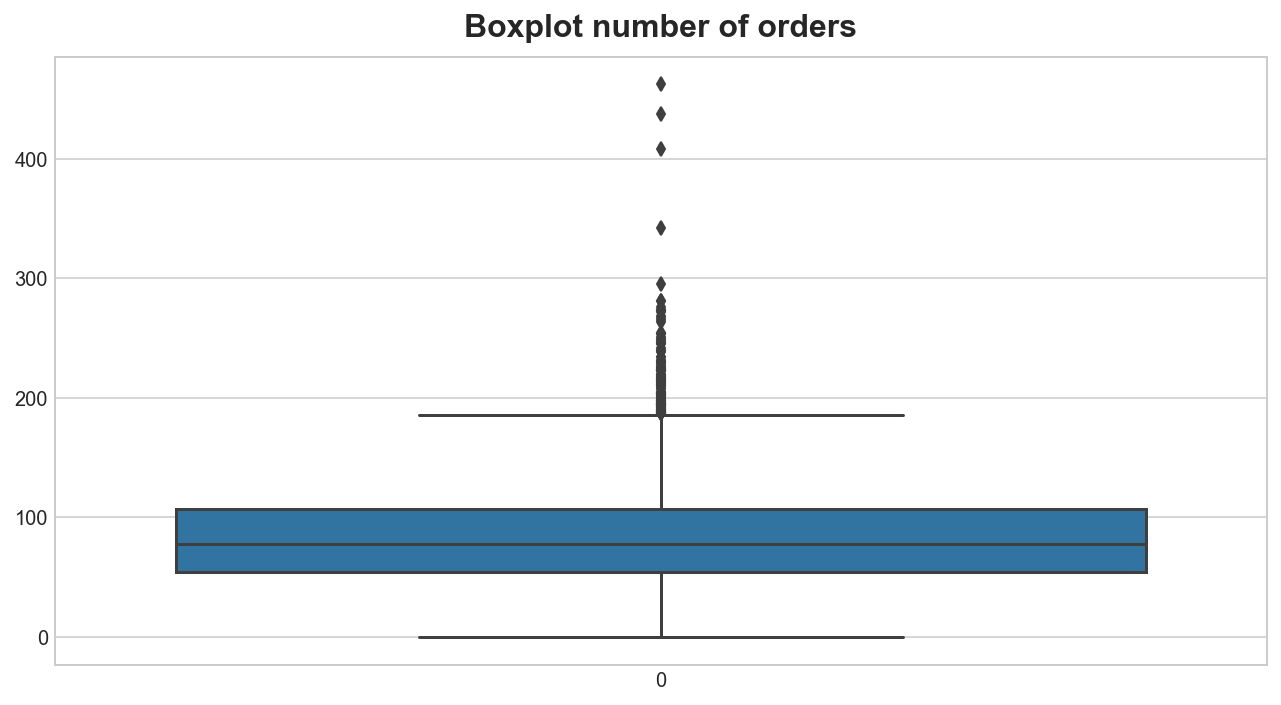

In [5]:
sns.boxplot(data = d1.num_orders)
plt.title('Boxplot number of orders');

We can see a small hourly dependence for the average orders number.

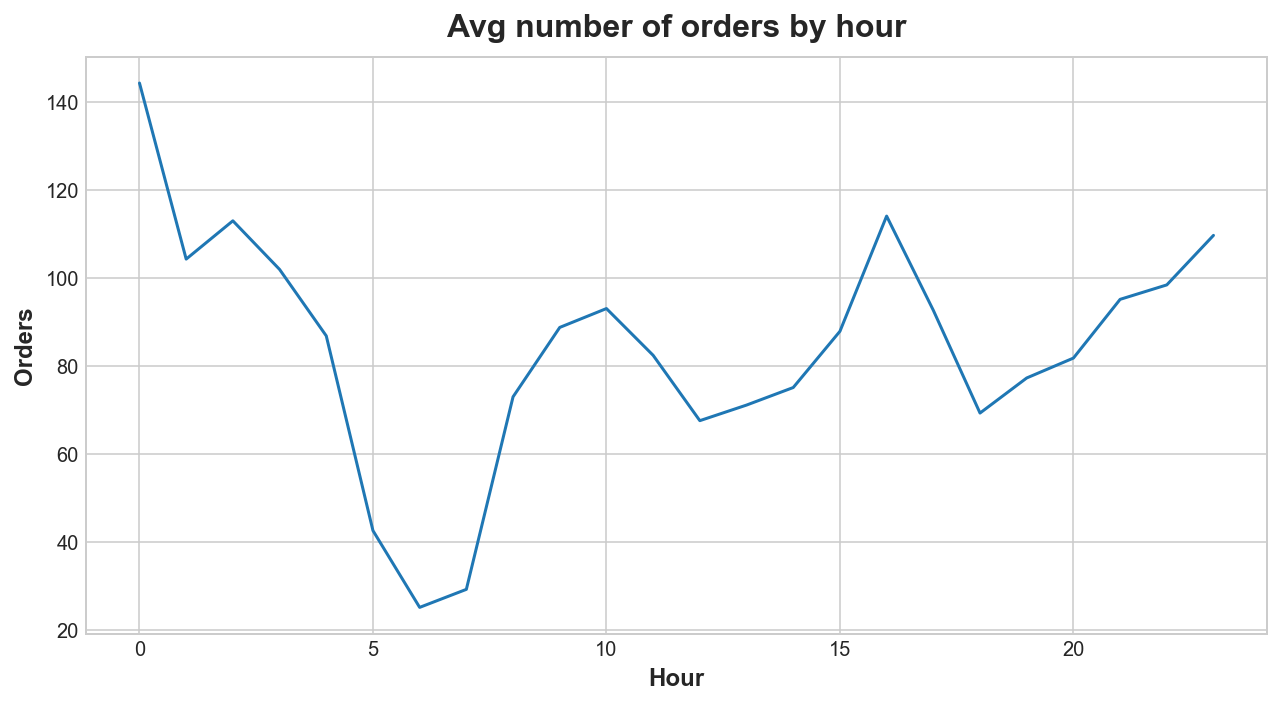

In [6]:
ax = d1.groupby("Hour").num_orders.mean().sort_index().plot(title = "Avg number of orders by hour", ylabel = "Orders");

Not fully balanced weekday distribution, moreover, when aggregated the dataset exhibits a weekday dependency as one would expect.

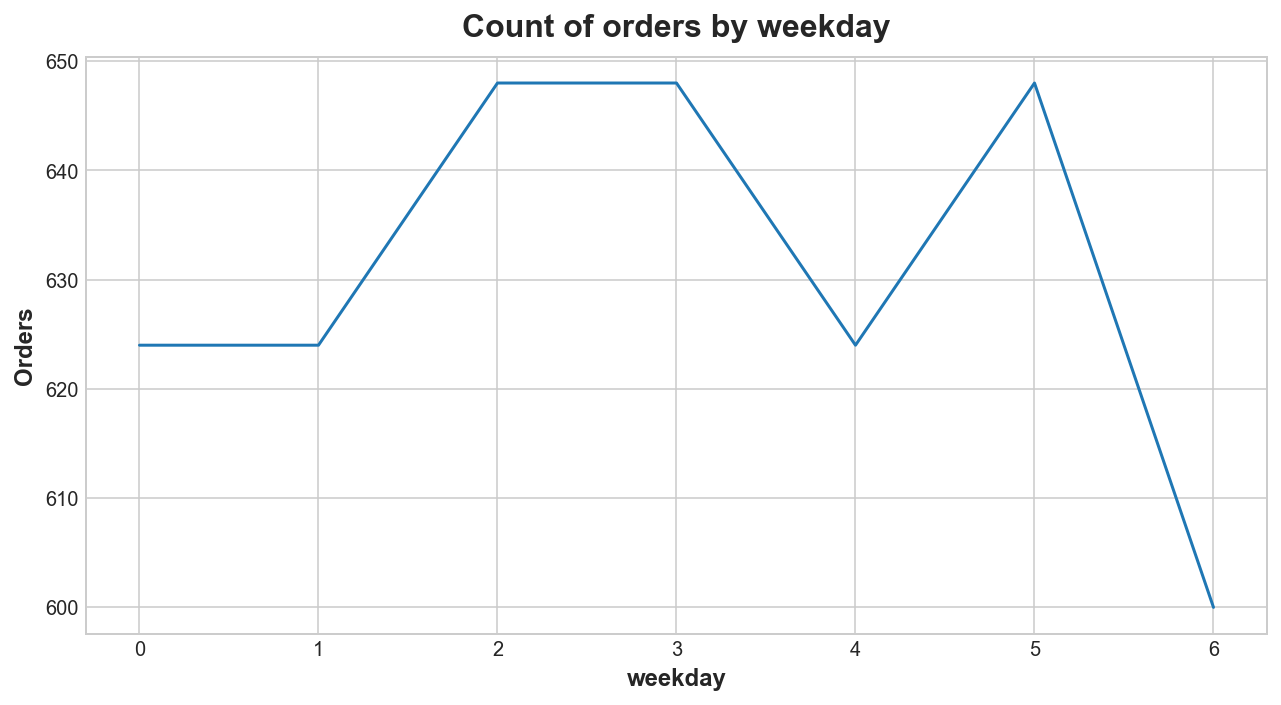

In [7]:
ax = d1.groupby("weekday").num_orders.count().sort_index().plot(title = "Count of orders by weekday", ylabel = "Orders");

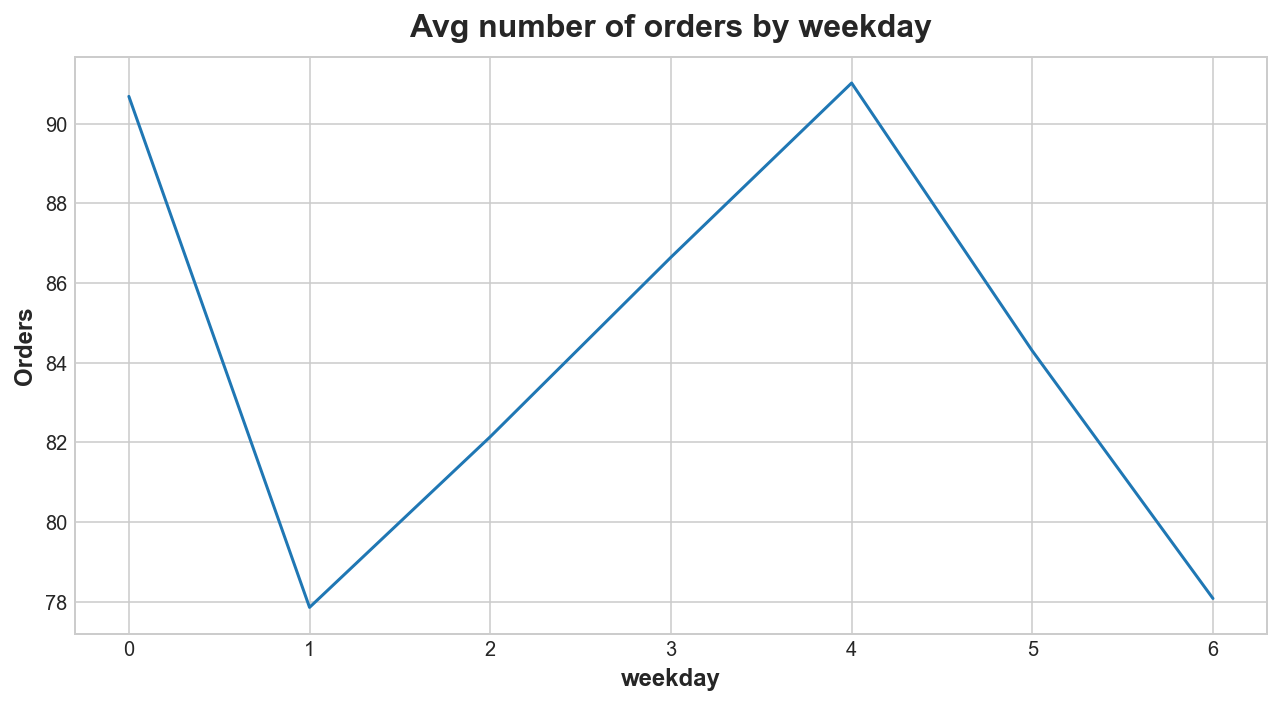

In [8]:
ax = d1.groupby("weekday").num_orders.mean().sort_index().plot(title = "Avg number of orders by weekday", ylabel = "Orders");

As discussed previously, clear difference in the available data per month. Aggregated we see an increasing tend into the summer season and a decreasing one in the winter season for taxi orders, which intuitively makes sense.

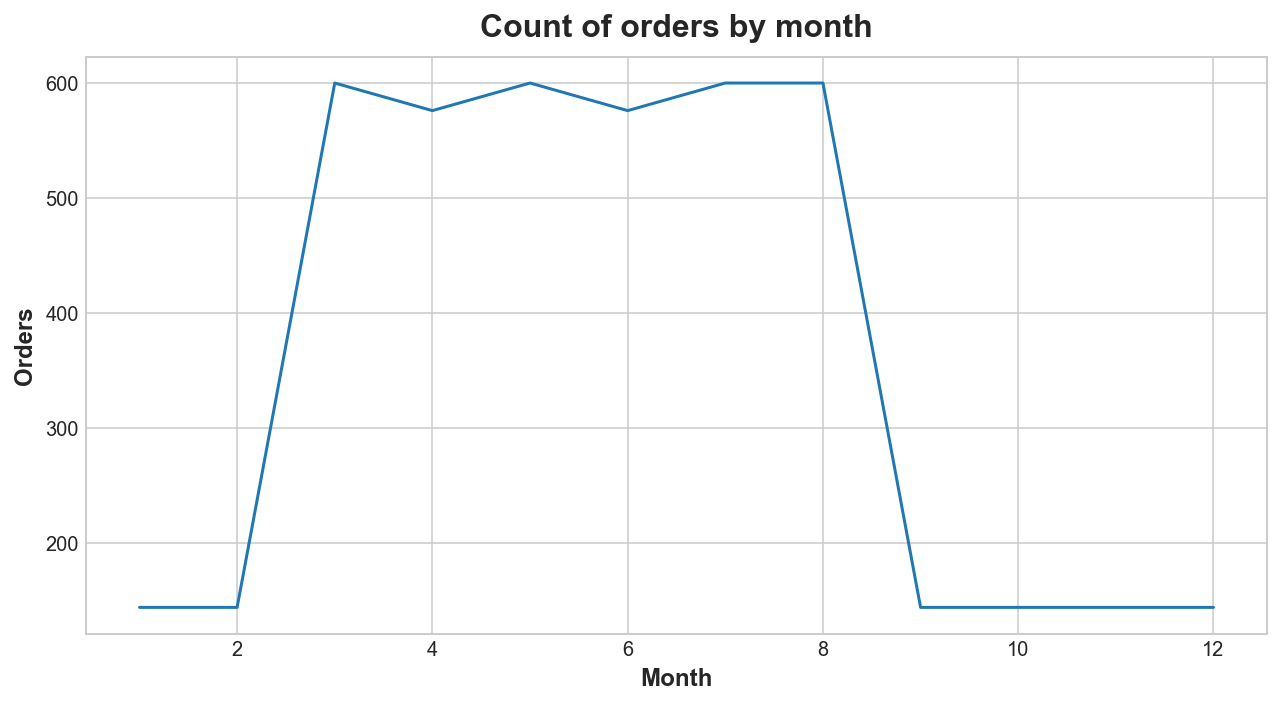

In [9]:
ax = d1.groupby("Month").num_orders.count().sort_index().plot(title = "Count of orders by month", ylabel = "Orders");

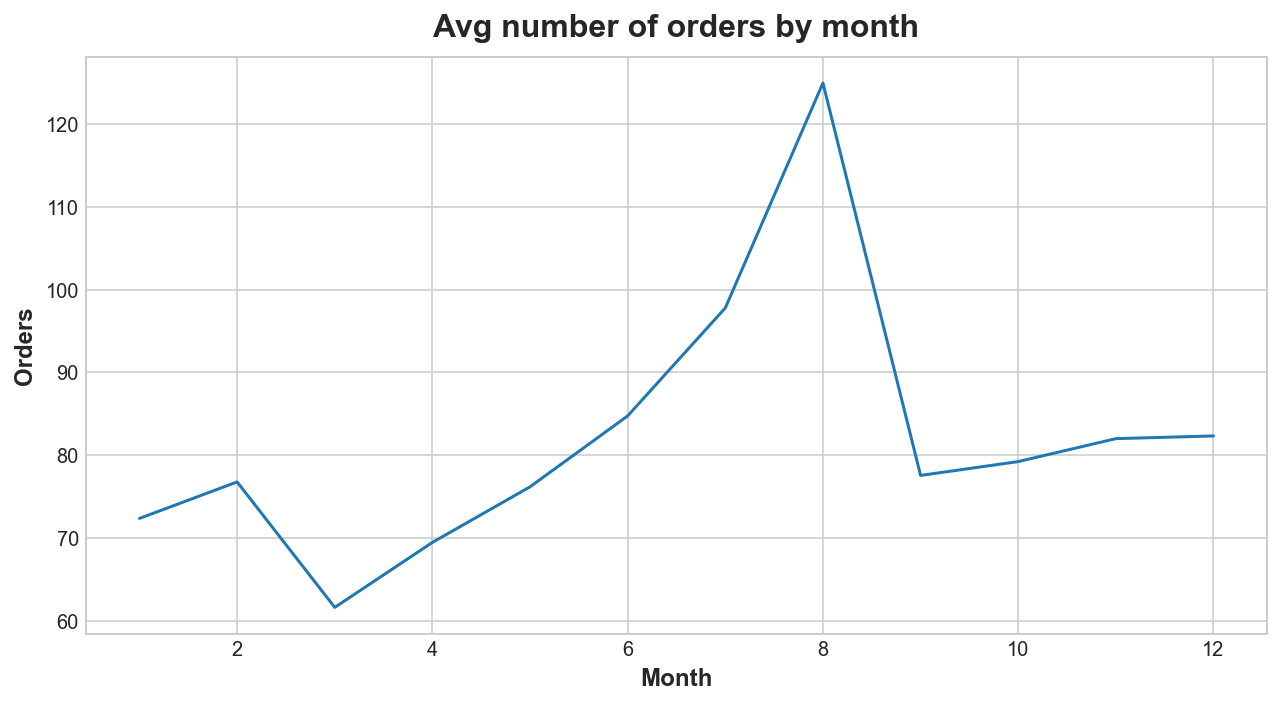

In [10]:
ax = d1.groupby("Month").num_orders.mean().sort_index().plot(title = "Avg number of orders by month", ylabel = "Orders");

As we mentioned earlier, the early part of the month is mostly captured while the middle-to-latter part is missing in many months.

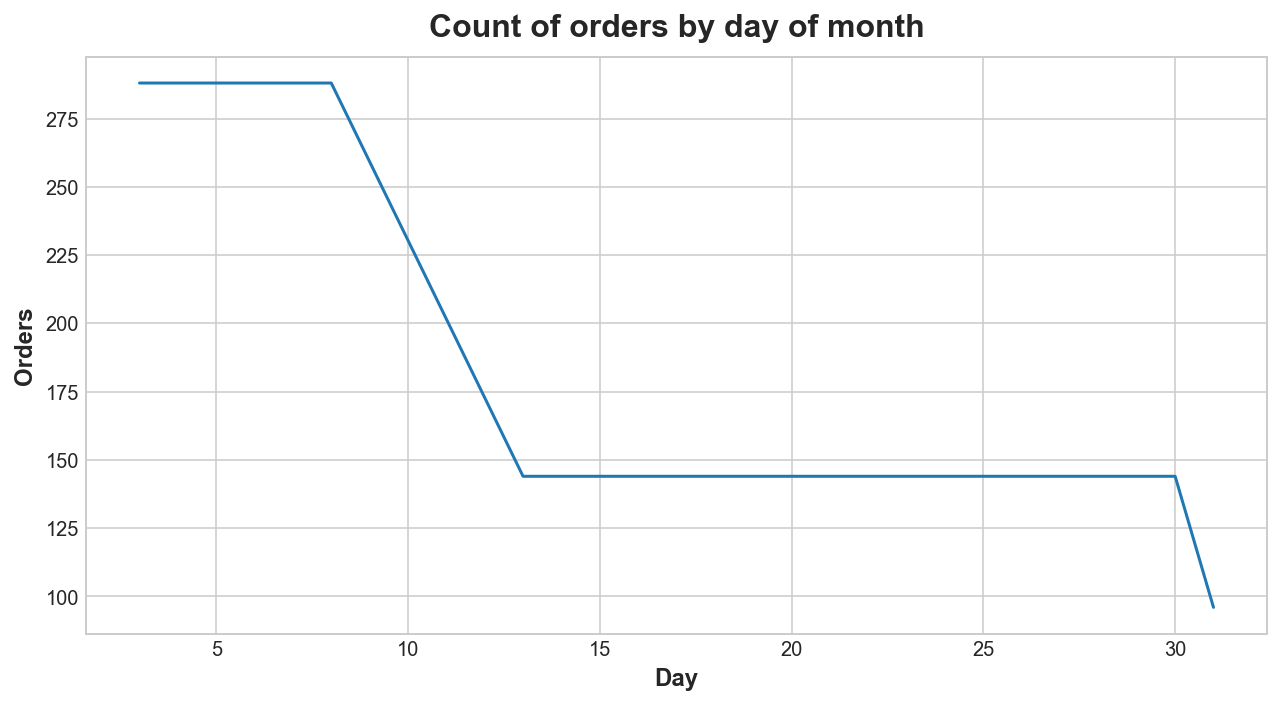

In [11]:
ax = d1.groupby("Day").num_orders.count().sort_index().plot(title = "Count of orders by day of month", ylabel = "Orders");

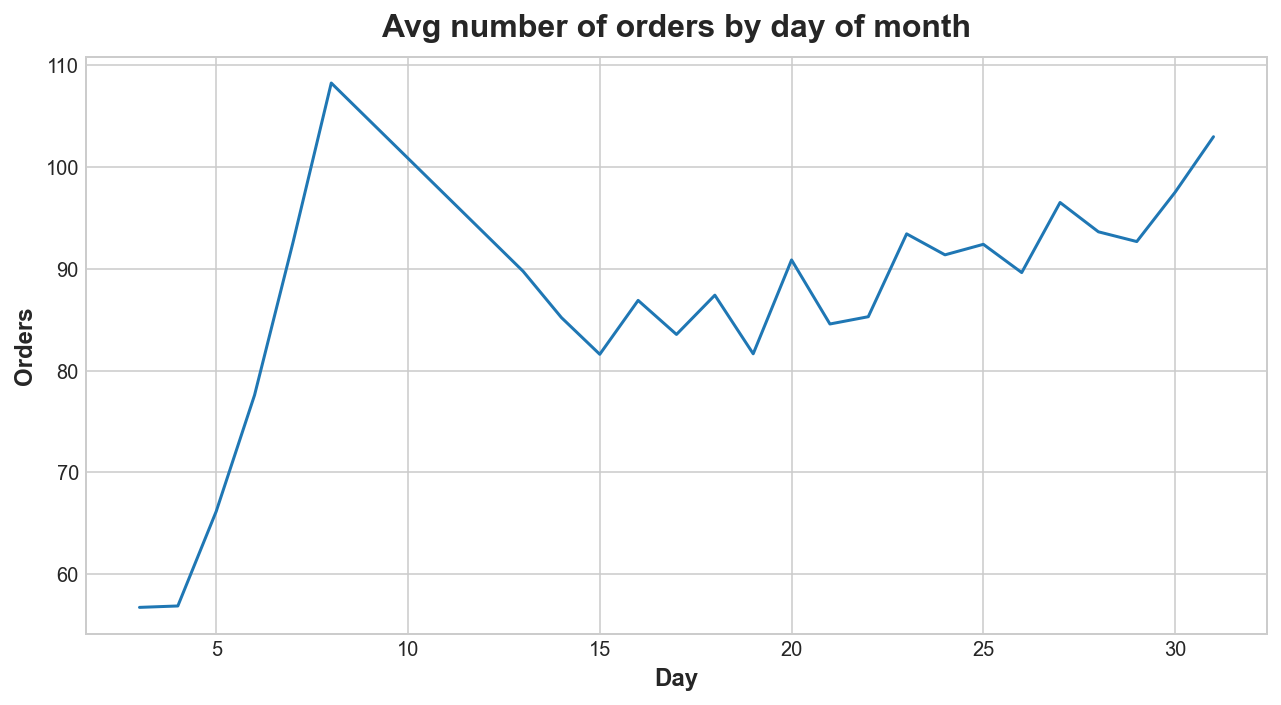

In [12]:
ax = d1.groupby("Day").num_orders.mean().sort_index().plot(title = "Avg number of orders by day of month", ylabel = "Orders");

# Time series modelling

Start by exploring a simple trend based model. Later on explore lag-based, heuristic-driven, trend-seasonal-cyclical, hybrid and finaly SARIMAX type model frameworks. Evaluate the model performance on a validation set attained by an 80-10-10 split. After choosing the final model, tune the model hyperparameters and report the test prediction result RMSE.

# Baseline trend model

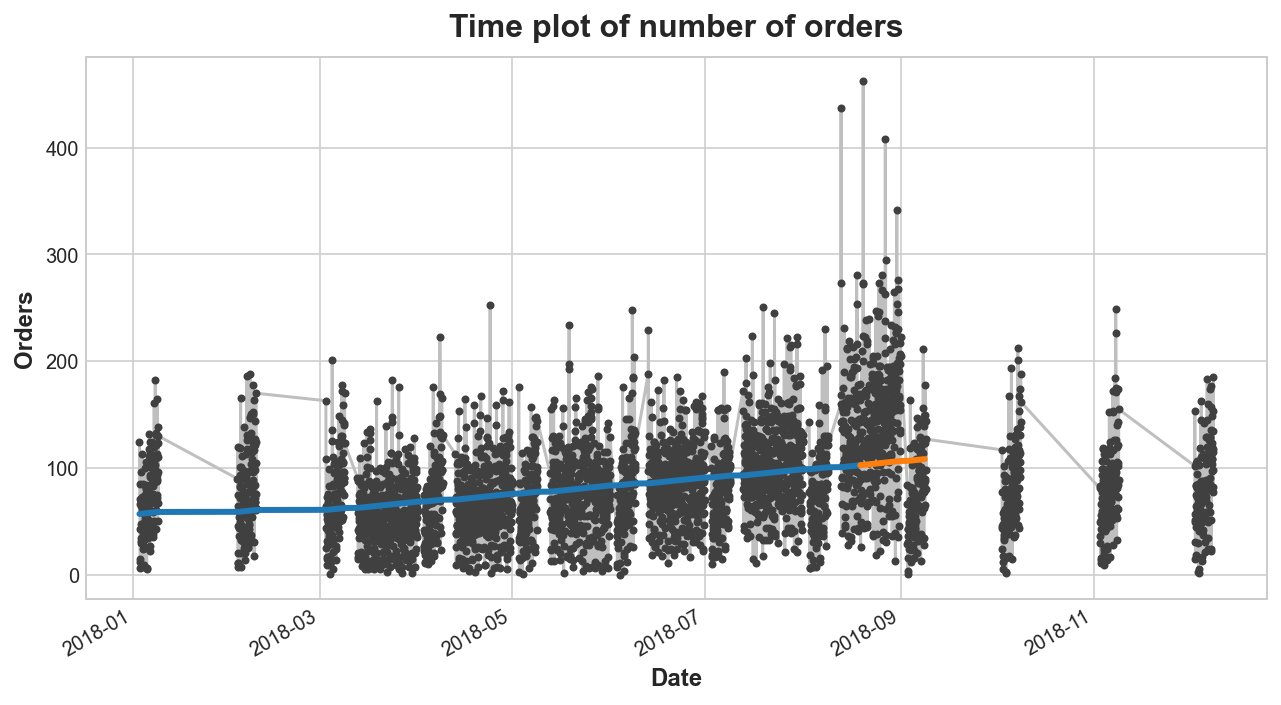

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error

d1_tot = d1.num_orders.to_frame()
d1_tot["Time"] = np.arange(len(d1_tot.index))

X = d1_tot.loc[:, ['Time']]      
y = d1_tot.loc[:, 'num_orders']  

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
y_fit = pd.Series(model.predict(X_train), index = X_train.index)
y_pred = pd.Series(model.predict(X_valid), index = X_valid.index)

ax = y.plot(**plot_params, ylabel = "Orders")
ax = y_fit.plot(ax = ax, linewidth = 3)
ax = y_pred.plot(ax = ax, linewidth = 3)
ax.set_title('Time plot of number of orders');

Plot the detrended series:

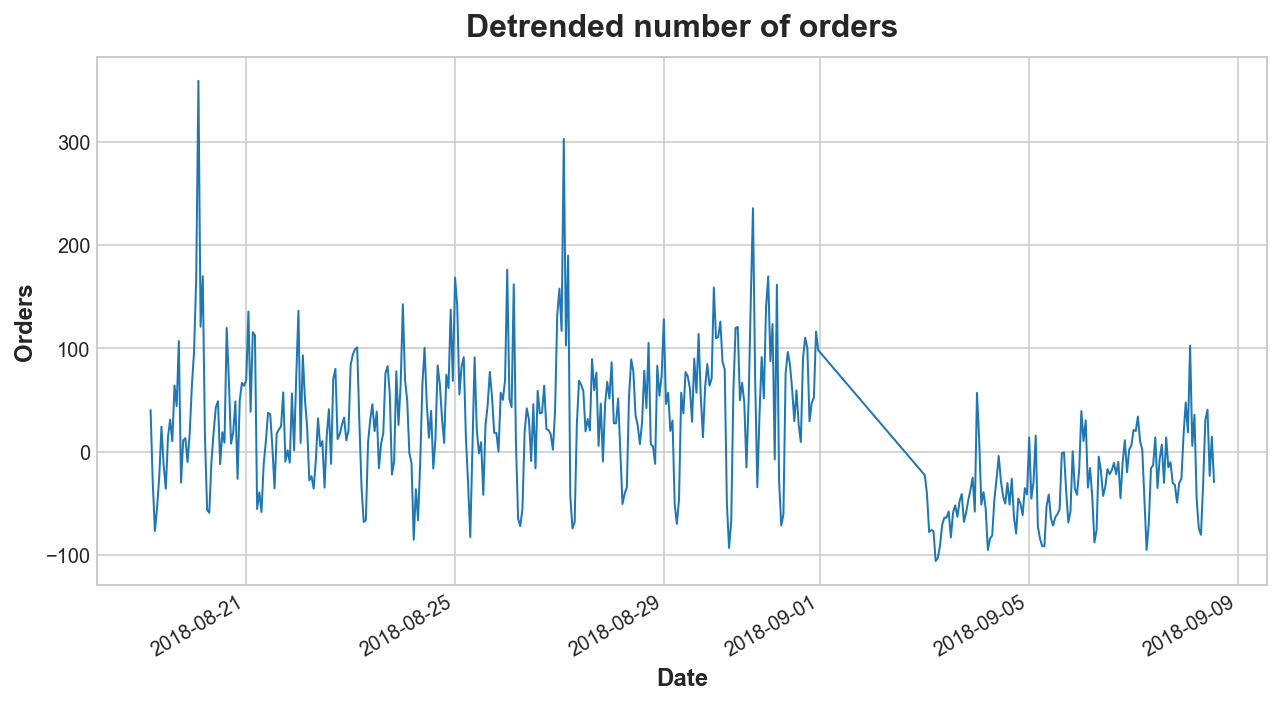

In [21]:
ax = (y_valid - y_pred).plot(linewidth = 1, ylabel = "Orders")
ax.set_title("Detrended number of orders");

In [22]:
rmse = ((y_valid-y_pred)**2).mean()**0.5
print(f'Baseline validation RMSE is equal to: {rmse:.3f}.')

Baseline validation RMSE is equal to: 67.167.


# Lag based linear regression

Build a regression model on its lag variables to analyse any lag-specific time dependencies. Start by exploring the lag_1 model to then analyse the ACF/PACF graphs for a more elaborate exploration.

In [23]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis = 1)

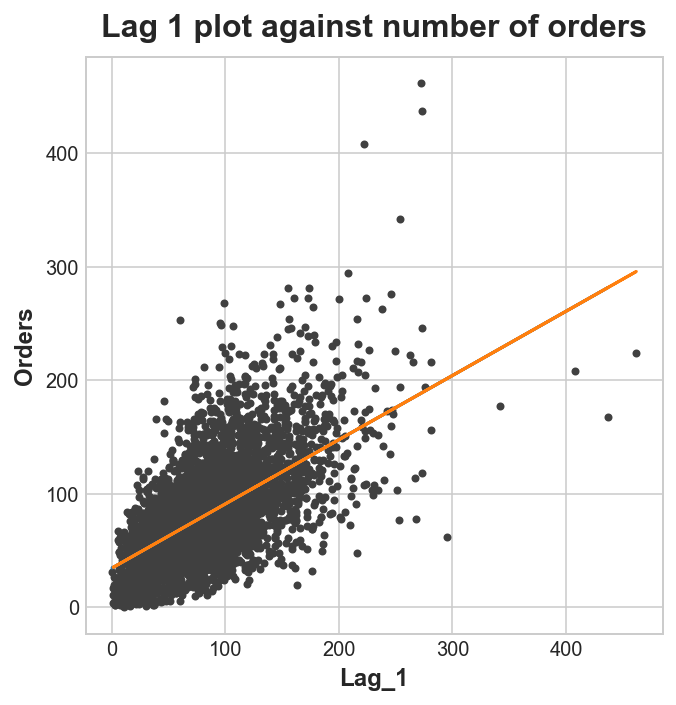

In [24]:
X = d1.num_orders.copy()
X = make_lags(X, [1])

X = X.loc[:, "y_lag_1"]
X.dropna(inplace = True)           # drop missing values in the feature set
y = d1_tot.loc[:, 'num_orders']    # create the target
y, X = y.align(X, join = 'inner')  # drop corresponding values in target
X = X.to_frame()
y = y.to_frame()

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = model.predict(X_train)
y_pred = model.predict(X_valid)

fig, ax = plt.subplots()
ax.plot(X['y_lag_1'], y, '.', color = '0.25')
ax.plot(X_train['y_lag_1'], y_fit)
ax.plot(X_valid['y_lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Orders')
ax.set_xlabel('Lag_1')
ax.set_title('Lag 1 plot against number of orders');

Lag_1 model validation RMSE: 53.437


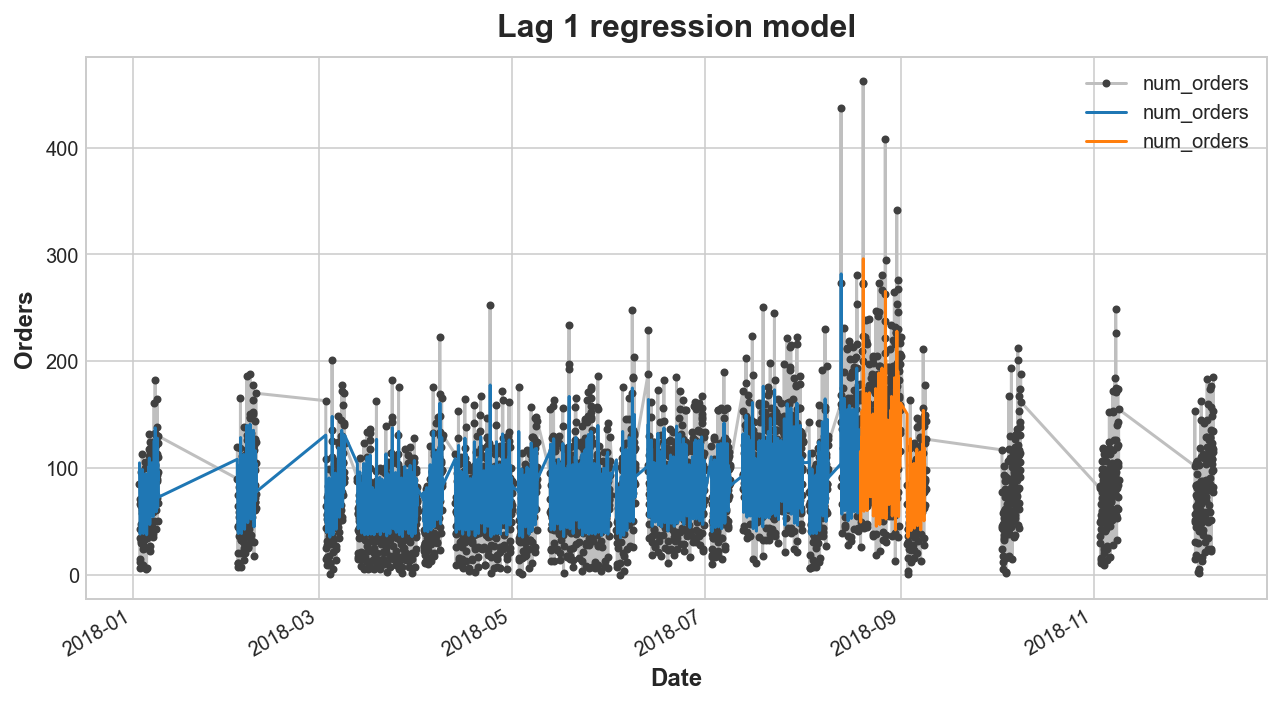

In [25]:
ax = y.plot(**plot_params, ylabel = "Orders")
ax.set_title('Lag 1 regression model')

y_fit = pd.DataFrame(y_fit)
y_fit.index = y_train.index
y_fit.columns = y_train.columns
ax = y_fit.plot(ax = ax)

y_pred = pd.DataFrame(y_pred)
y_pred.index = y_valid.index
y_pred.columns = y_valid.columns
ax = y_pred.plot(ax = ax)

rmse2 = mean_squared_error(y_valid, y_pred) ** 0.5
print(f'Lag_1 model validation RMSE: {rmse2:.3f}')

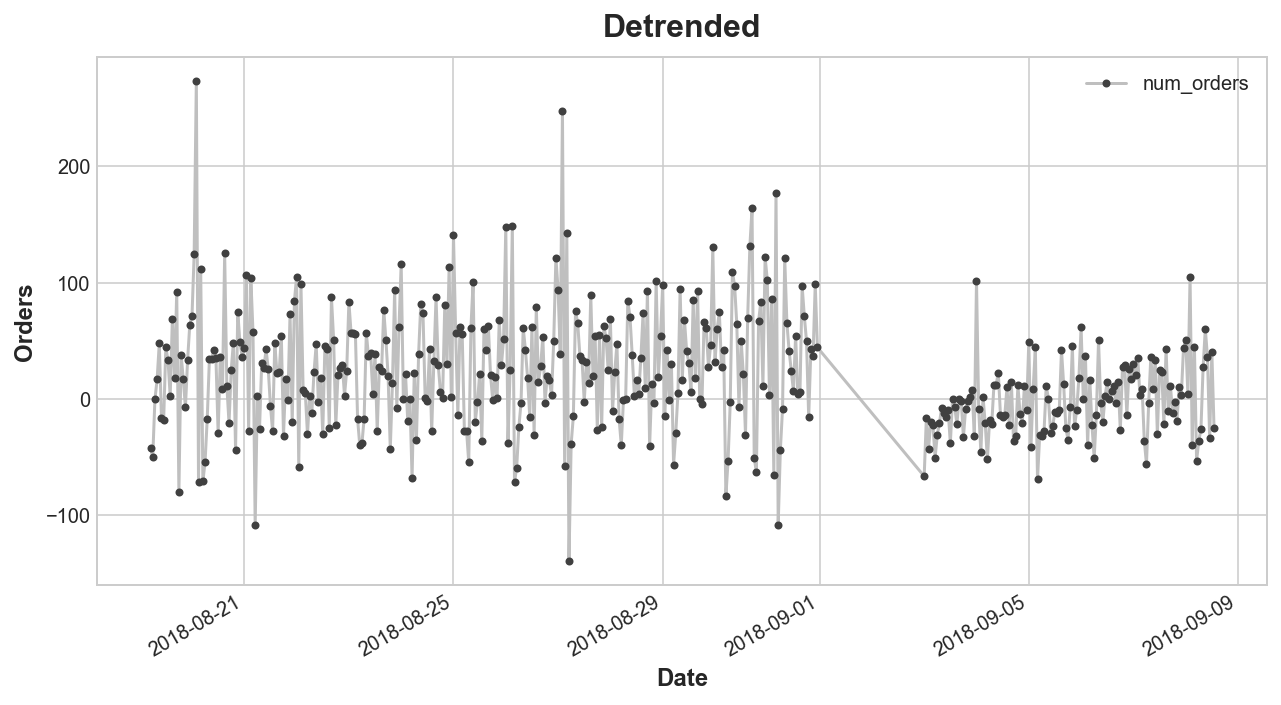

In [26]:
detrended = y_valid - y_pred
ax = detrended.plot(**plot_params, ylabel = "Orders", title = "Detrended")

The regression on the lag 1 was fairly strong. Let's take a look at other lags and the ACF/PACFs.

In [27]:
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

def lagplot(x, y = None, lag = 1, standardize = False, ax = None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha = 0.75,
        s = 3,
    )
    line_kws = dict(color = 'C3', )
    ax = sns.regplot(x = x_,
                     y = y_,
                     scatter_kws = scatter_kws,
                     line_kws = line_kws,
                     lowess = True,
                     ax = ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop = dict(size = "large"),
        frameon = True,
        loc = "upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title = f"Lag {lag}", xlabel = x_.name, ylabel = y_.name)
    return ax

def plot_lags(x, y = None, lags = 6, nrows = 1, lagplot_kwargs = {}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex = True, sharey = True, squeeze = False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag = k + 1, ax = ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict = dict(fontsize = 14))
            ax.set(xlabel = "", ylabel = "")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel = x.name)
    plt.setp(axs[:, 0], ylabel = y.name if y is not None else x.name)
    fig.tight_layout(w_pad = 0.1, h_pad = 0.1)
    return fig

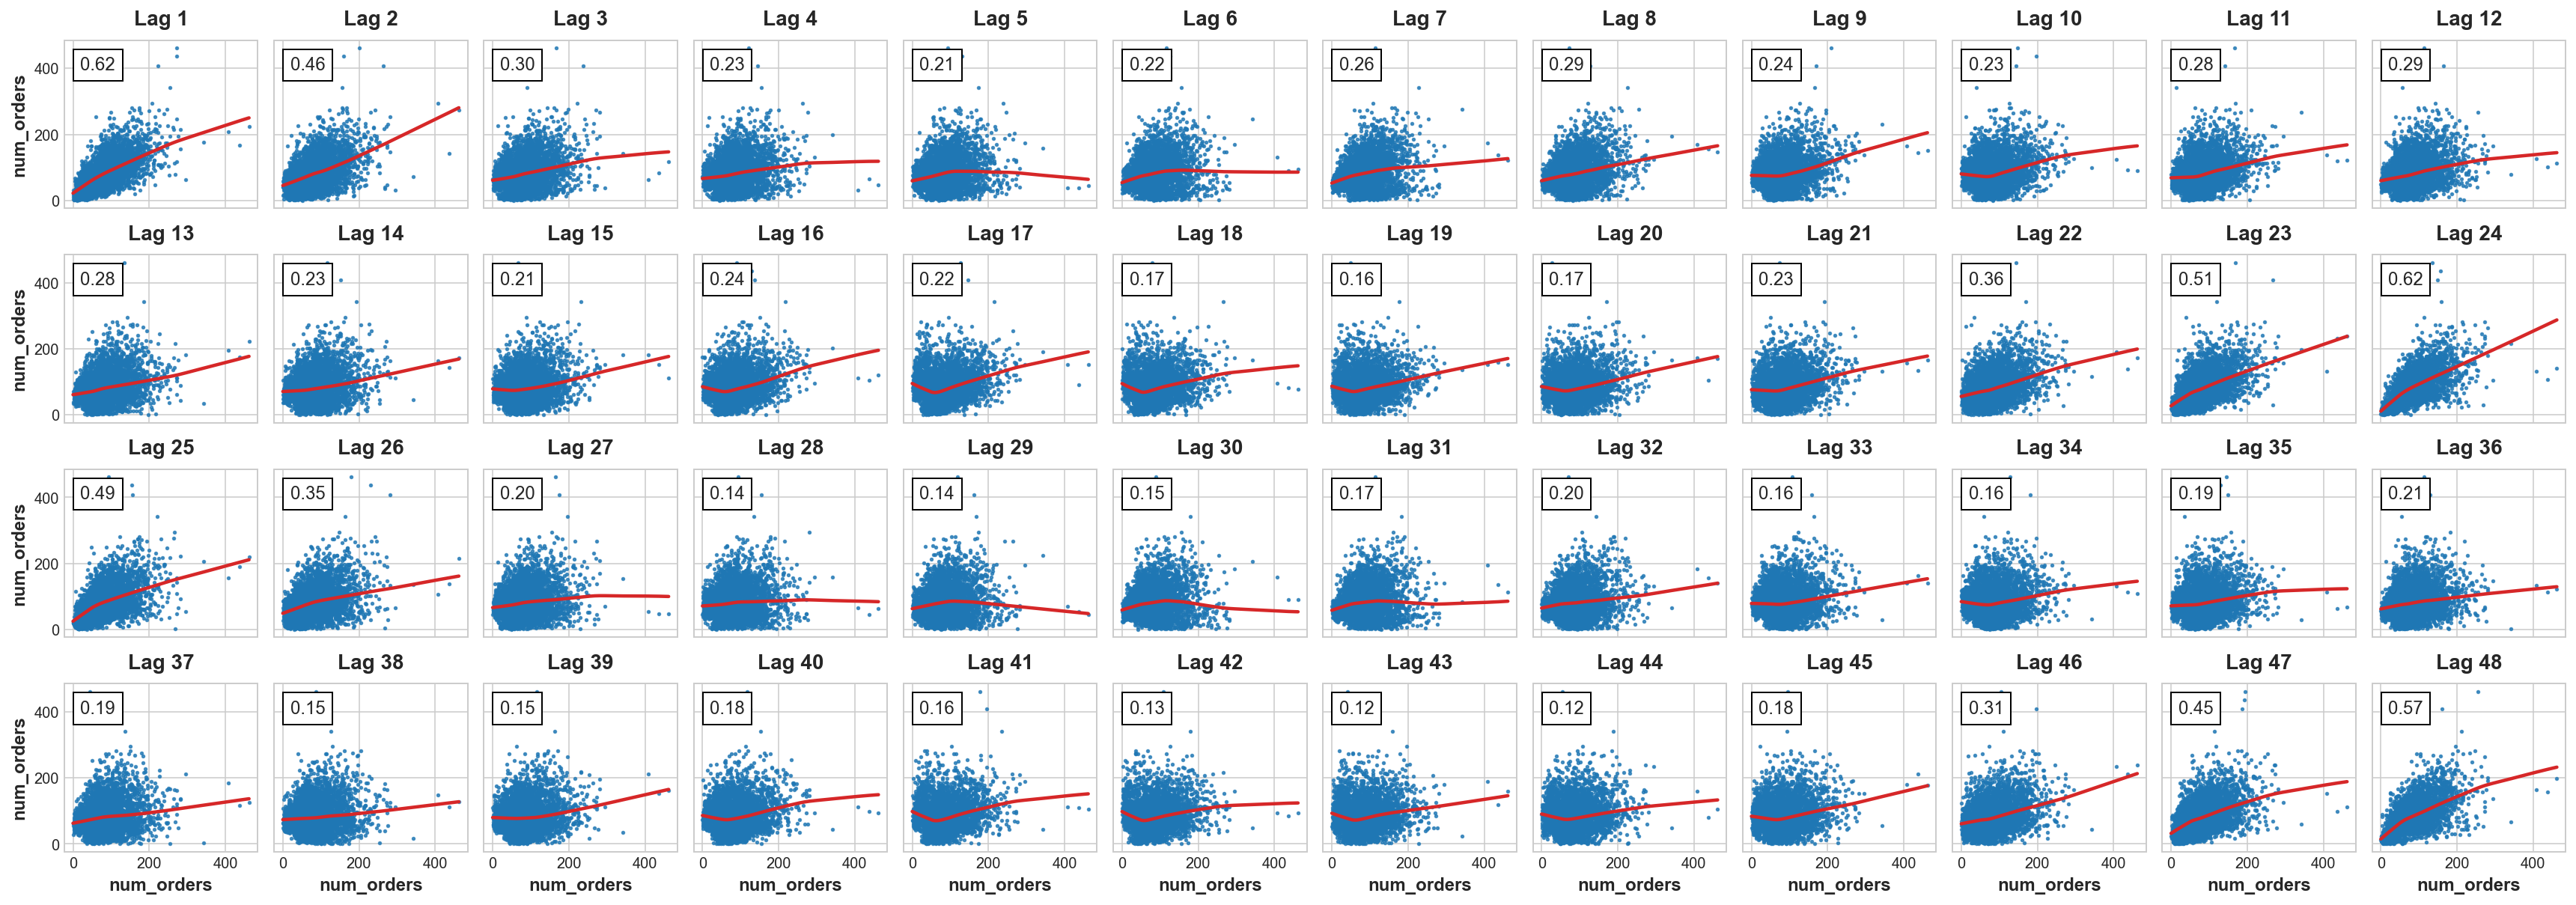

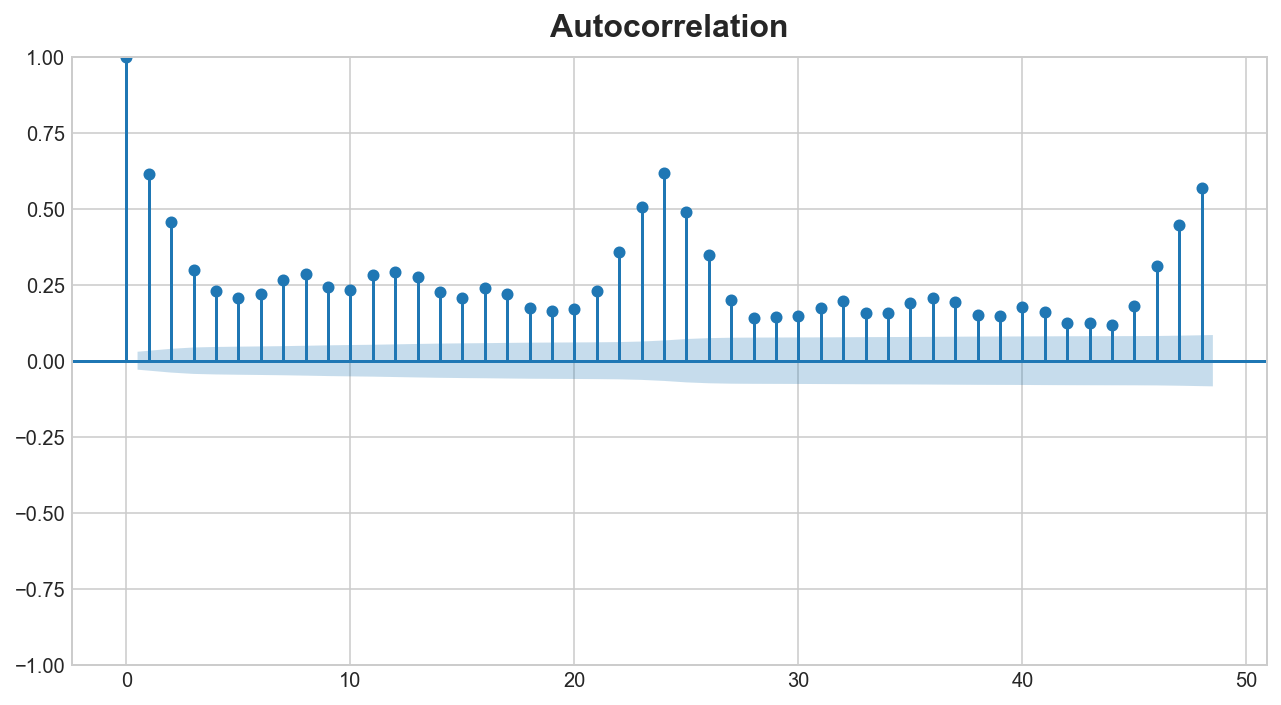

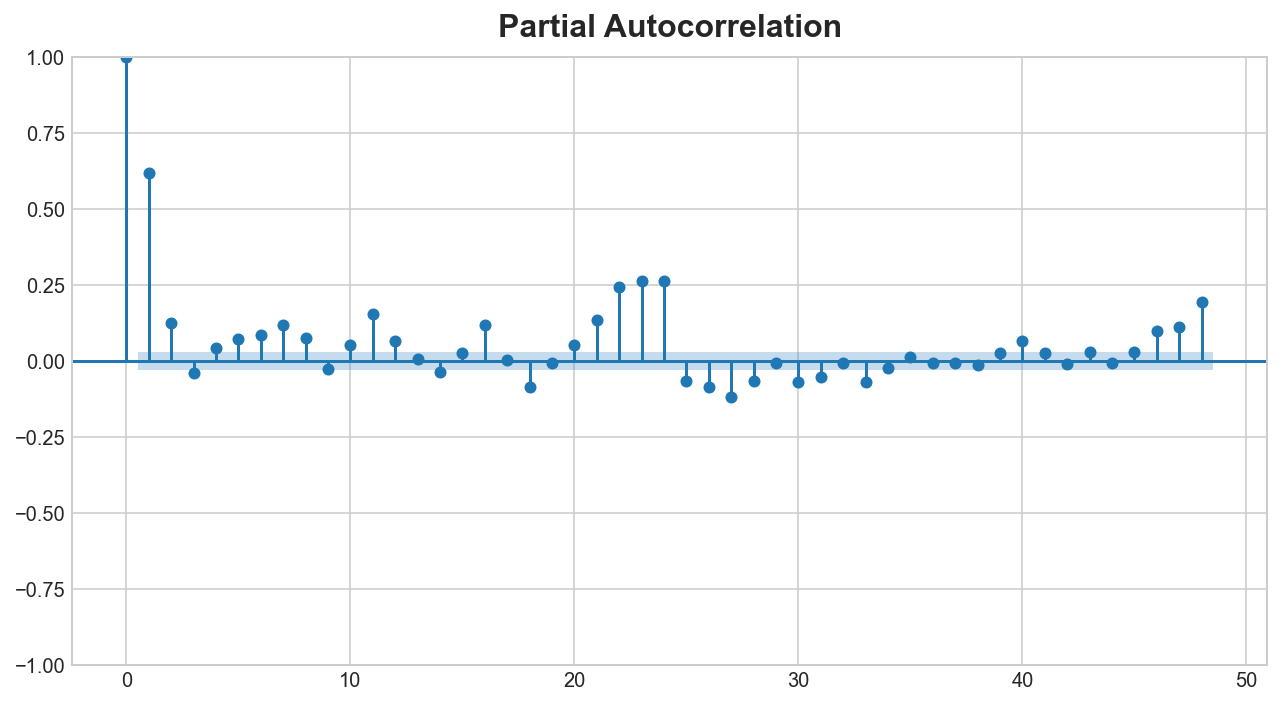

In [28]:
y = d1_tot.loc[:, 'num_orders']  
_ = plot_lags(y, lags = 48, nrows = 4)

_ = plot_acf(y, lags = 48)
_ = plot_pacf(y, lags = 48)

We can see that the lags 1, 24 and 48 capture most of the ACF/PACF dependencies in our dataset. Let's build a model using these three lags present.

In [29]:
y = d1_tot.num_orders.copy()
X = make_lags(y, lags = [1, 24, 48]).dropna()
y, X = y.align(X, join = 'inner')

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index = y_train.index)
y_pred = pd.Series(model.predict(X_valid), index = y_valid.index)

rmse_train3 = mean_squared_error(y_train, y_fit) ** 0.5
rmse_valid3 = mean_squared_error(y_valid, y_pred) ** 0.5
print(f'Training RMSE: {rmse_train3:.5f}')
print(f'Validation RMSE: {rmse_valid3:.5f}')

Training RMSE: 27.97338
Validation RMSE: 46.35685


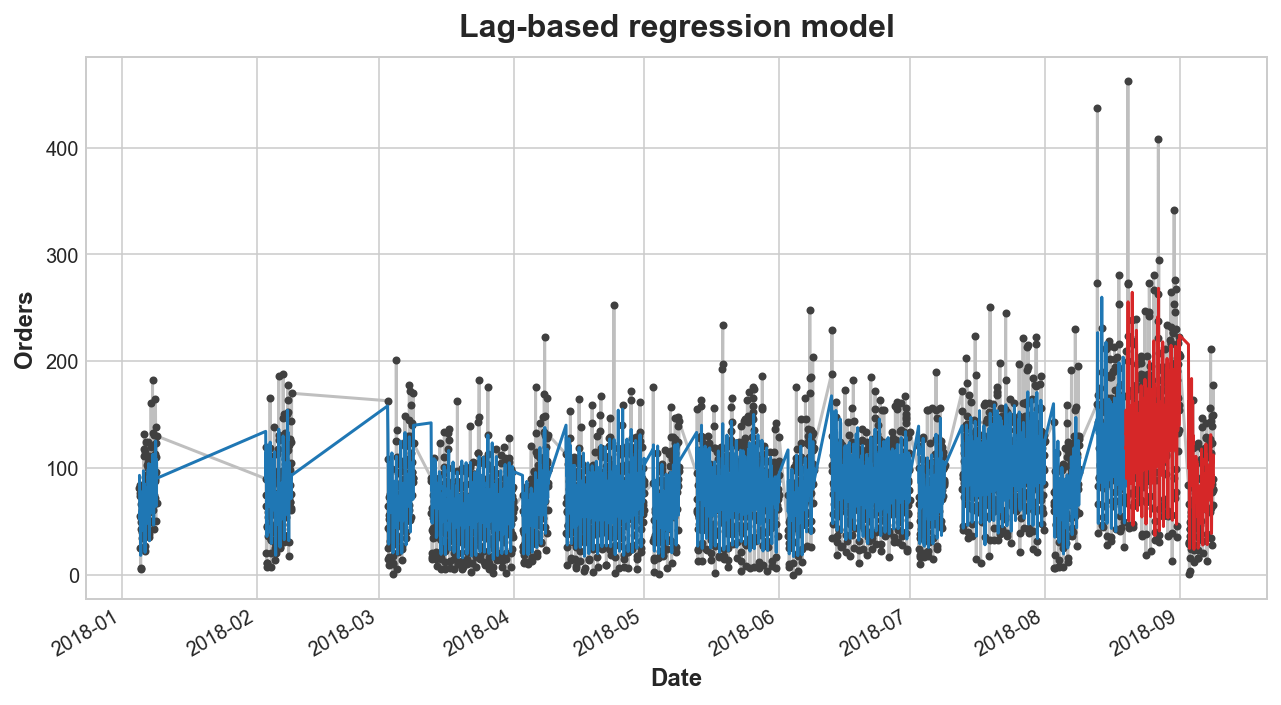

In [30]:
ax = y_train.plot(**plot_params, ylabel = "Orders", title = "Lag-based regression model")
ax = y_valid.plot(**plot_params)
ax = y_fit.plot(ax = ax)
_ = y_pred.plot(ax = ax, color = 'C3')

Using various lags we got some more predictive power. Let's now focus on heuristics-driven model to find a better fit.

# Heuristics based model

The idea here is to engineer features to capture the dependencies of the model. Given that we have little data available for a thorough time-series analysis (say proper SARIMAX, LSTM models) by creating clever features the hope is to gain predictive power. Features include time-specific data as well as previous performances of in-group or running-averages.

Possible ways forward would be adding momentum based indicators and holiday-specific signals. For the latter given the airport region one can easily incorporate a holiday schedule to account for increased traffic in and around the airports.

In [63]:
import math

d1_lt = pd.DataFrame(d1.groupby("Date").num_orders.sum())
d1_lt["Month"] = d1_lt.index.month
d1_lt["Hour"] = d1_lt.index.hour
d1_lt["weekday"] = d1_lt.index.weekday
#d1_lt["weekday_sin"] = d1_lt.index.weekday.map(lambda x: math.sin((x+1)*2*math.pi/7))
#d1_lt["weekday_cos"] = d1_lt.index.weekday.map(lambda x: math.cos((x+1)*2*math.pi/7))
#d1_lt["hour_sin"] = d1_lt.index.Hour.map(lambda x: math.sin((x+1)*2*math.pi/24))
#d1_lt["hour_cos"] = d1_lt.index.Hour.map(lambda x: math.cos((x+1)*2*math.pi/24))

Explore features using the previously found lags as well as running daily and weekly mean/stdevs as well as rolling average of hour and weekday specific group data.

In [64]:
d1_lt["Lag_1"] = d1_lt.num_orders.shift(1)
d1_lt["Lag_24"] = d1_lt.num_orders.shift(24)
d1_lt["Lag_48"] = d1_lt.num_orders.shift(48)
d1_lt["MA24"] = d1_lt.num_orders.rolling(24).mean().shift(1)
d1_lt["MStd24"] = d1_lt.num_orders.rolling(24).std().shift(1)
d1_lt["MA168"] = d1_lt.num_orders.rolling(168).mean().shift(1)
d1_lt["MStd168"] = d1_lt.num_orders.rolling(168).std().shift(1)
d1_lt["Avg_group"] = d1_lt.groupby(["weekday", "Hour"]).num_orders.transform(lambda x: x.rolling(52, 1).mean().shift(1))
d1_lt["Prev_group"] = d1_lt.groupby(["weekday", "Hour"]).num_orders.apply(lambda x: x.shift(1))
d1_lt["Prev_group2"] = d1_lt.groupby(["weekday", "Hour"]).num_orders.apply(lambda x: x.shift(2))
d1_lt.dropna(inplace = True)

num_orders         Month          Hour       weekday     Lag_1  \
num_orders     1.000000  2.418700e-01  8.962595e-04 -2.082736e-02  0.617563   
Month          0.241870  1.000000e+00  4.573611e-16 -4.937145e-02  0.240614   
Hour           0.000896  4.573611e-16  1.000000e+00 -1.072475e-16 -0.078881   
weekday       -0.020827 -4.937145e-02 -1.072475e-16  1.000000e+00 -0.025109   
Lag_1          0.617563  2.406141e-01 -7.888117e-02 -2.510934e-02  1.000000   
Lag_24         0.622690  2.395205e-01  3.261882e-03  1.648789e-02  0.510309   
Lag_48         0.576589  2.338714e-01 -6.464559e-04 -6.100991e-04  0.455976   
MA24           0.518747  4.184168e-01  9.282712e-04 -2.443840e-02  0.545989   
MStd24         0.367607  3.157000e-01 -2.564454e-03 -1.001915e-01  0.413699   
MA168          0.418988  5.403661e-01  6.472503e-04 -4.747611e-02  0.424122   
MStd168        0.315485  5.311773e-01  1.213984e-04 -5.116910e-02  0.323283   
Avg_group      0.615384  2.012537e-01  6.484203e-02 -4.995667e-02  0.414377   
Prev_group     0.574280  2.835853e-01  1.588093e-03 -3.107573e-02  0.405798   
Prev_group2    0.482662  3.324684e-01  4.309120e-03 -3.390877e-02  0.339033   

               Lag_24    Lag_48      MA24    MStd24     MA168   MStd168  \
num_orders   0.622690  0.576589  0.518747  0.367607  0.418988  0.315485   
Month        0.239521  0.233871  0.418417  0.315700  0.540366  0.531177   
Hour         0.003262 -0.000646  0.000928 -0.002564  0.000647  0.000121   
weekday      0.016488 -0.000610 -0.024438 -0.100191 -0.047476 -0.051169   
Lag_1        0.510309  0.455976  0.545989  0.413699  0.424122  0.323283   
Lag_24       1.000000  0.622540  0.545641  0.445576  0.460380  0.352264   
Lag_48       0.622540  1.000000  0.391148  0.307424  0.474843  0.371863   
MA24         0.545641  0.391148  1.000000  0.796052  0.776948  0.593160   
MStd24       0.445576  0.307424  0.796052  1.000000  0.608927  0.565069   
MA168        0.460380  0.474843  0.776948  0.608927  1.000000  0.839178   
MStd168      0.352264  0.371863  0.593160  0.565069  0.839178  1.000000   
Avg_group    0.555207  0.581806  0.105726  0.094927  0.147795  0.164548   
Prev_group   0.488056  0.535452  0.265383  0.201880  0.411107  0.424888   
Prev_group2  0.448584  0.493561  0.188577  0.159234  0.277018  0.310348   

             Avg_group  Prev_group  Prev_group2  
num_orders    0.615384    0.574280     0.482662  
Month         0.201254    0.283585     0.332468  
Hour          0.064842    0.001588     0.004309  
weekday      -0.049957   -0.031076    -0.033909  
Lag_1         0.414377    0.405798     0.339033  
Lag_24        0.555207    0.488056     0.448584  
Lag_48        0.581806    0.535452     0.493561  
MA24          0.105726    0.265383     0.188577  
MStd24        0.094927    0.201880     0.159234  
MA168         0.147795    0.411107     0.277018  
MStd168       0.164548    0.424888     0.310348  
Avg_group     1.000000    0.701230     0.721077  
Prev_group    0.701230    1.000000     0.572924  
Prev_group2   0.721077    0.572924     1.000000

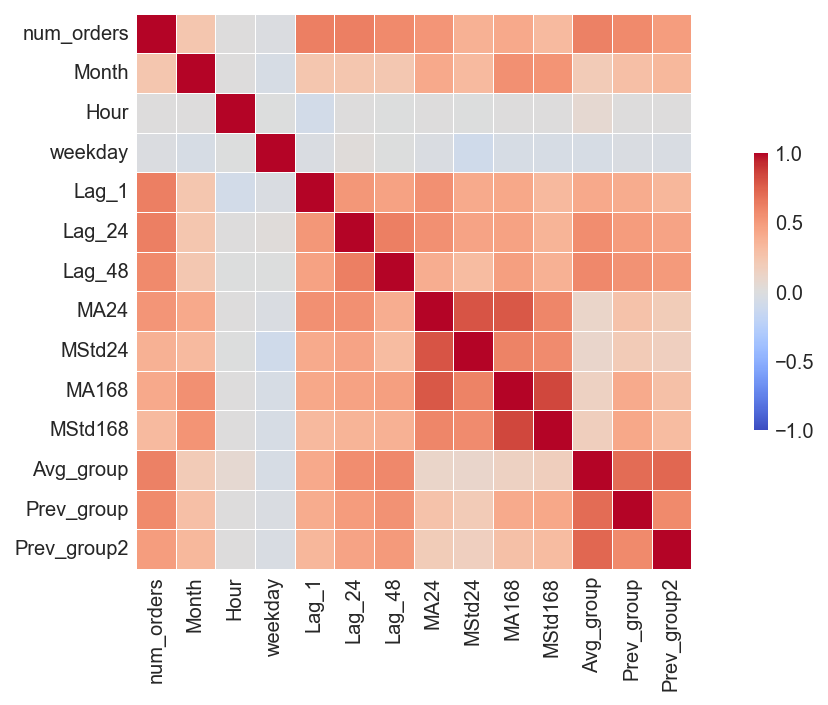

In [33]:
display(d1_lt.corr(method = 'pearson'))
ax = sns.heatmap(d1_lt.corr(method = 'pearson'), vmax = 1, vmin = -1, center = 0,
               square = True, linewidth = 0.5, cbar_kws = {"shrink": 0.5}, annot = False, fmt = ".2f", cmap = "coolwarm");

In [34]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

def make_mi_scores(X, y):
    '''
    Creat MI scores for the dataset X with response y, using mutual_info_regression
    
    X: independent variables
    y: target variable
    '''
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores


def plot_mi_scores(scores):
    '''
    Plot the MI scores in decreasing order
    
    scores: MI scores of the features
    '''
    
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()

The important features we find are the ones one would expect: last day's results, the hour of the day and the average group performance.

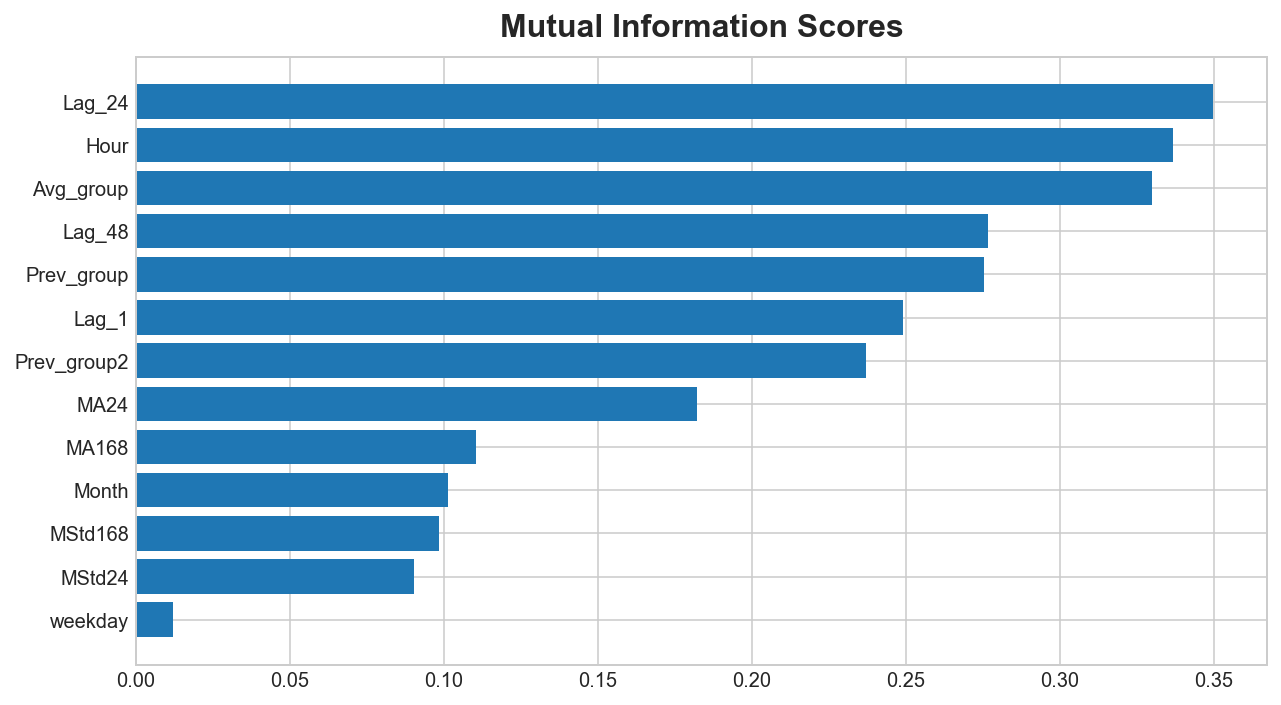

In [35]:
X = d1_lt.copy()
y = X.pop("num_orders")

mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

In [36]:
X = d1_lt.copy()
y = X.pop("num_orders")

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

model = XGBRegressor()
model.fit(X_train, y_train)

baseline_score = mean_squared_error(y_valid, model.predict(X_valid))**0.5
print(f"XGBRegressor baseline score: {baseline_score:.3f} RMSE")

XGBRegressor baseline score: 45.003 RMSE


In [37]:
def drop_uninformative(df, mi_scores):
    '''
    Drop variables from the dataset df, which have 0 MI scores
    
    df: pandas dataframe
    mi_scores: MI scores of df
    '''
    
    return df.loc[:, mi_scores > 0.0]

X = d1_lt.copy()
y = X.pop("num_orders")
X = drop_uninformative(X, mi_scores)

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

model = XGBRegressor()
model.fit(X_train, y_train)

baseline_score = mean_squared_error(y_valid, model.predict(X_valid))**0.5
print(f"Baseline score: {baseline_score:.3f} RMSE")

Baseline score: 45.003 RMSE


By building a simple XGBRegressor model we find that the validation RMSE performance further increased from the lag-based model setup, from 46.4 to 45.

Training RMSE: 6.64142
Validation RMSE: 45.00258


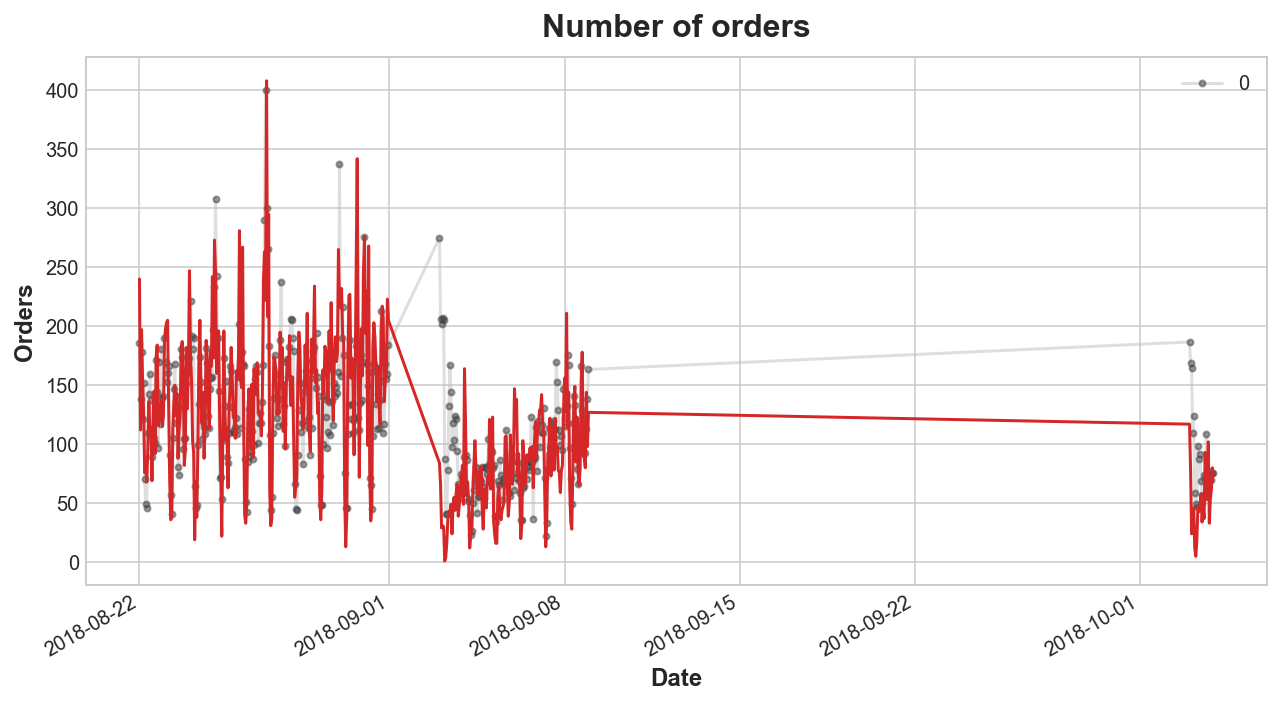

In [38]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

model = XGBRegressor()
model.fit(X_train, y_train)

y_fit = model.predict(X_train).clip(0.0)
y_pred = model.predict(X_valid).clip(0.0)
y_pred = pd.DataFrame(y_pred)
y_pred.index = y_valid.index

rmse_train1 = mean_squared_error(y_train, y_fit) ** 0.5
rmse_valid1 = mean_squared_error(y_valid, y_pred) ** 0.5
print(f'Training RMSE: {rmse_train1:.5f}')
print(f'Validation RMSE: {rmse_valid1:.5f}')

ax = pd.DataFrame(y_pred).plot(**plot_params, alpha = 0.5, title = "Number of orders", ylabel = "Orders")
ax = y_valid.plot(ax = ax, label = "Forecast", color = 'C3');

Analysing the feature importance metrics of the model we see that the average of the group and the lag_24 metrics together with the lag_1 metric are fairly predictive while some of the other features are less important.

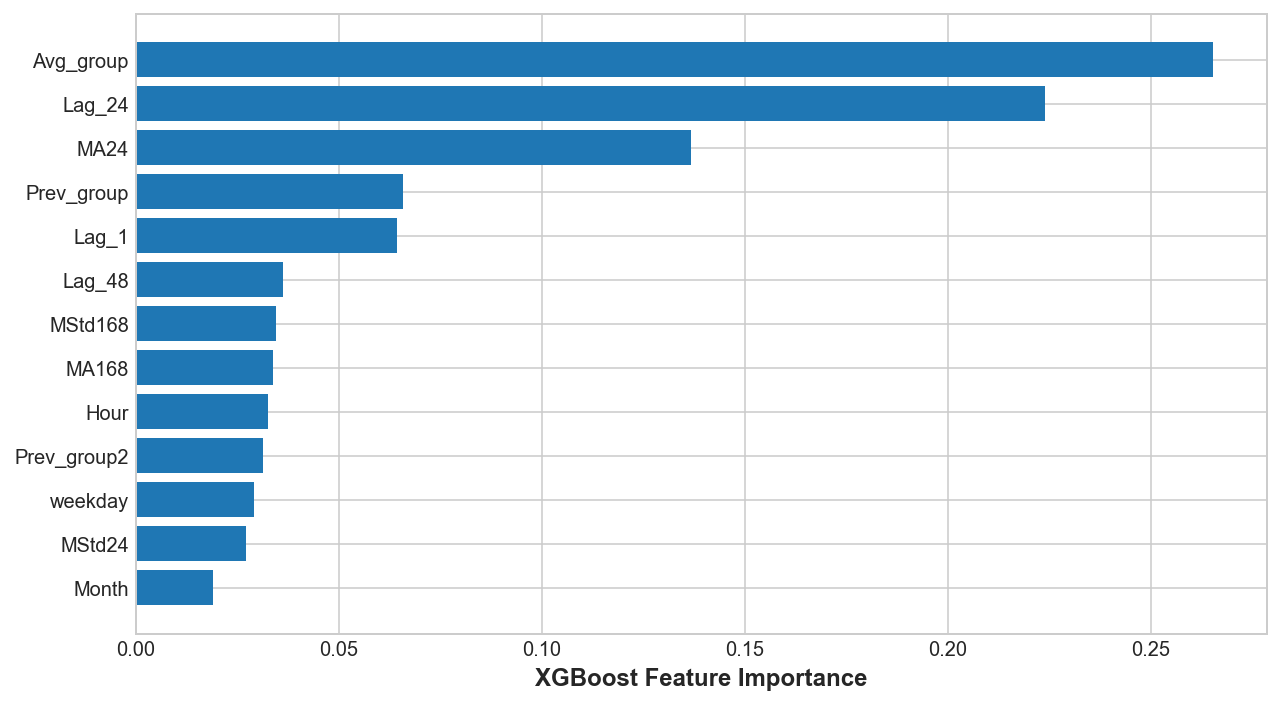

In [39]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_valid.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance");

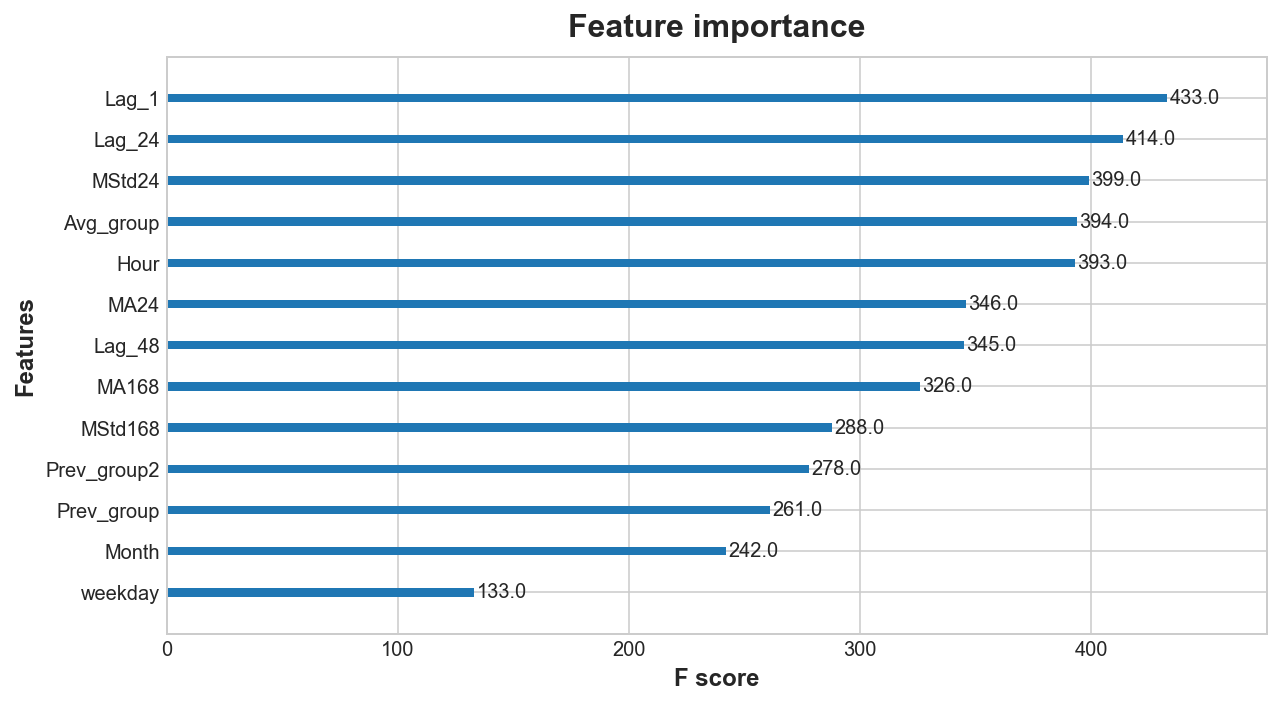

In [40]:
from xgboost import plot_importance
plot_importance(model);

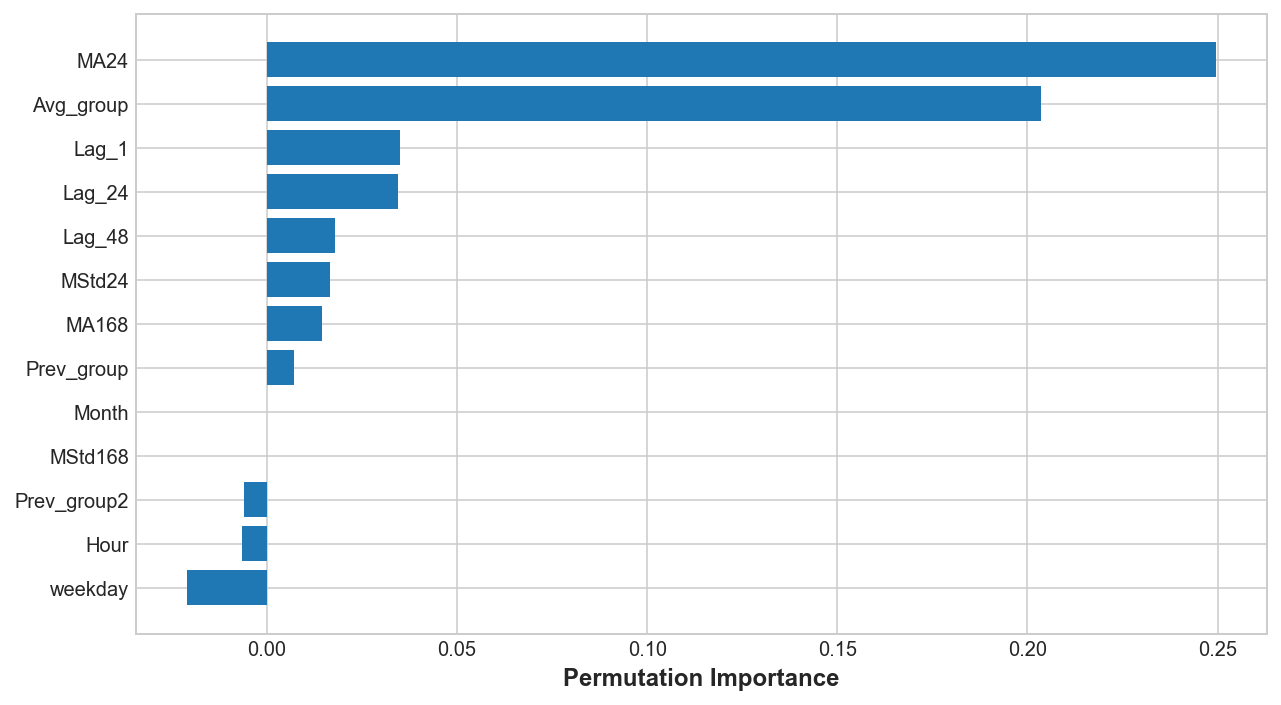

In [41]:
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model, X_valid, y_valid)

sorted_idx = perm_imp.importances_mean.argsort()
plt.barh(X_valid.columns[sorted_idx], perm_imp.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

# Explore trend-seasonal-cyclical models

Next, let's analyse the model from a seasonality perspective. Earlier we have analysed the trend-based model but let's add seasonal elements to the mix and later add cyclical, lag-based elements to create our Trend-seasonal-cyclical model.

## Trend + Seasonal Model

Introduce seasonality to the model through dummy variables in the daily data + looking for Fourier features.

In [42]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype = np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

def seasonal_plot(X, y, period, freq, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors = X[period].nunique(),)
    ax = sns.lineplot(
        x = freq,
        y = y,
        hue = period,
        data = X,
        ci = False,
        ax = ax,
        palette = palette,
        legend = False,
    )
    ax.set_title(f"Seasonal Plot ({period} / {freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy = (1, y_),
            xytext = (6, 0),
            color = line.get_color(),
            xycoords = ax.get_yaxis_transform(),
            textcoords = "offset points",
            size = 14,
            va = "center",
        )
    return ax

def plot_periodogram(ts, detrend = 'linear', ax = None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1h")
    freqencies, spectrum = periodogram(
        ts,
        fs = fs,
        detrend = detrend,
        window = "boxcar",
        scaling = 'spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color = "purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 52, 365, 8760])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Weekly (52)",
            "Daily (365)",
            "Hourly (8760)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [43]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

X = d1_lt.copy()

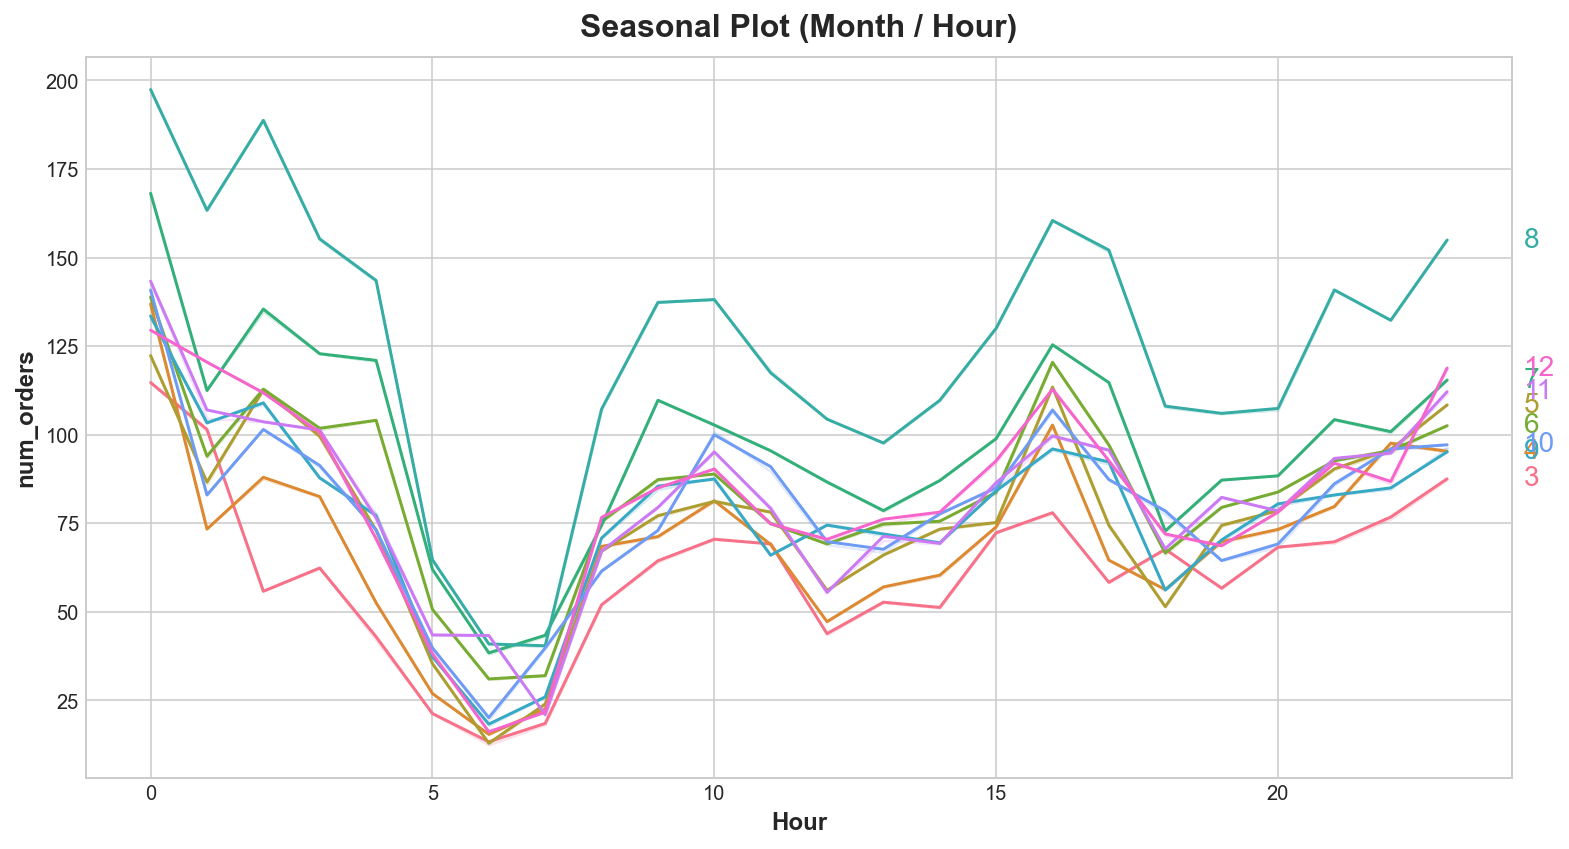

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (11, 6))
seasonal_plot(X, y = "num_orders", period = "Month", freq = "Hour", ax = ax);

We see strong seasonality in the data on a daily level.

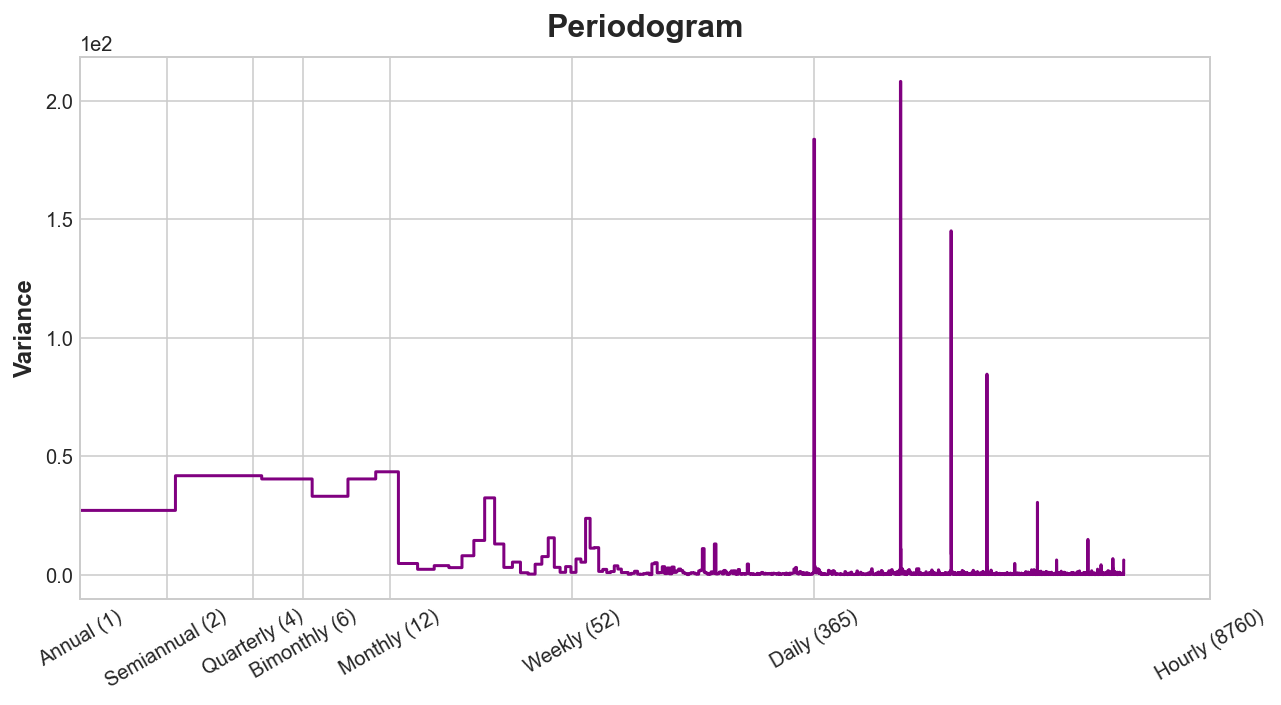

In [45]:
plot_periodogram(X.num_orders);

Let's now add the seasonal elements using fourier features as well as daily dummy variables. The model performance is still quite lacking when compared with our earlier approaches.

In [46]:
from statsmodels.tsa.deterministic import Fourier, Seasonality, TimeTrend

four = Fourier(period = 184, order = 1)
seas = Seasonality(period = 24)

dp = DeterministicProcess(
    index = d1_lt.index,
    constant = True,               # dummy feature for bias (y-intercept)
    order = 1,                     # trend (order 1 means linear)
    seasonal = False,              
    additional_terms=[seas, four],
    drop = True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()
y = d1_lt["num_orders"]

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

# Fit and predict
model = LinearRegression(fit_intercept = False)  
model.fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index = y_train.index)
y_pred = pd.Series(model.predict(X_valid), index = y_valid.index)

rmse_train5 = mean_squared_error(y_train, y_fit) ** 0.5
rmse_valid5 = mean_squared_error(y_valid, y_pred) ** 0.5
print(f'Training RMSE: {rmse_train5:.3f}')
print(f'Validation RMSE: {rmse_valid5:.3f}')

Training RMSE: 28.984
Validation RMSE: 54.730


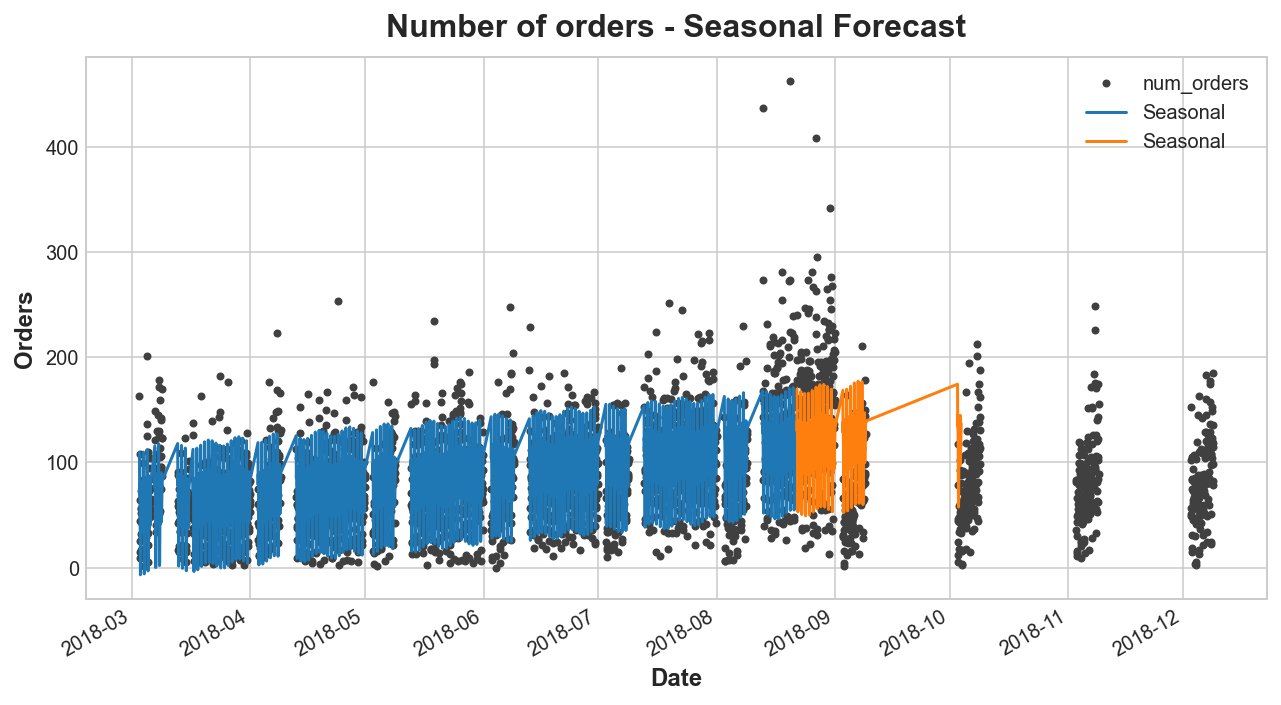

In [47]:
ax = y.plot(color = '0.25', style = '.', title = "Number of orders - Seasonal Forecast", ylabel = "Orders")
ax = y_fit.plot(ax = ax, label = "Seasonal")
ax = y_pred.plot(ax = ax, label = "Seasonal")
_ = ax.legend()

We can observe that the daily frequency components smoothened out, we have captured the daily fluctuations in the data.

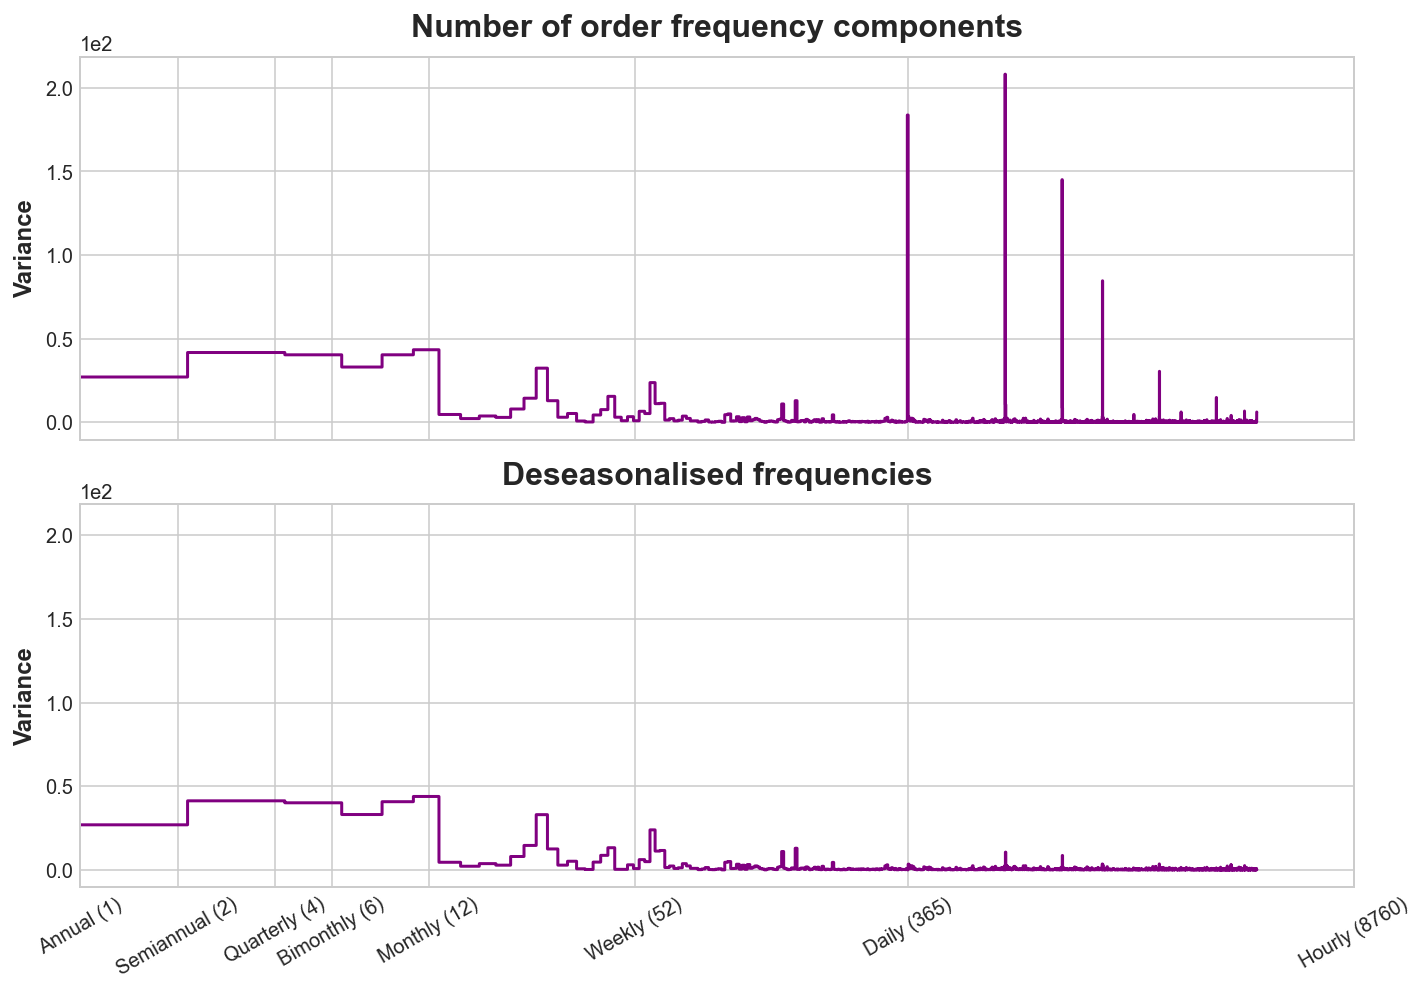

In [48]:
_ = model.fit(X, y)
y_pred = pd.Series(model.predict(X), index = y.index)

y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (10, 7))
ax1 = plot_periodogram(y, ax = ax1)
ax1.set_title("Number of order frequency components")
ax2 = plot_periodogram(y_deseason, ax = ax2);
ax2.set_title("Deseasonalised frequencies");

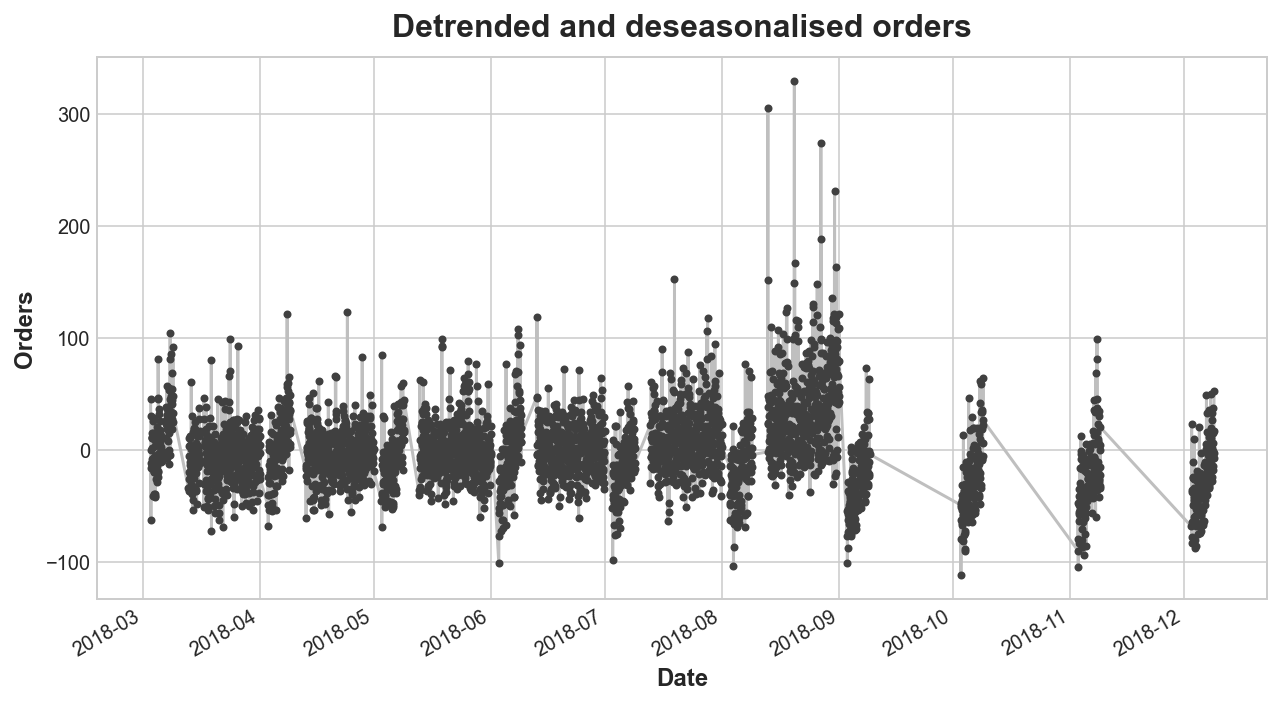

In [49]:
y_deseason.plot(**plot_params, title = "Detrended and deseasonalised orders", ylabel = 'Orders');

# Trend + Seasonality + Cyclical Model

Add now the earlier found 1, 24 and 48 lag elements to further refine the model output. The model performance further increased to 40.4 from 45 of the Heuristics based model.

Training RMSE: 24.312
Validation RMSE: 40.376


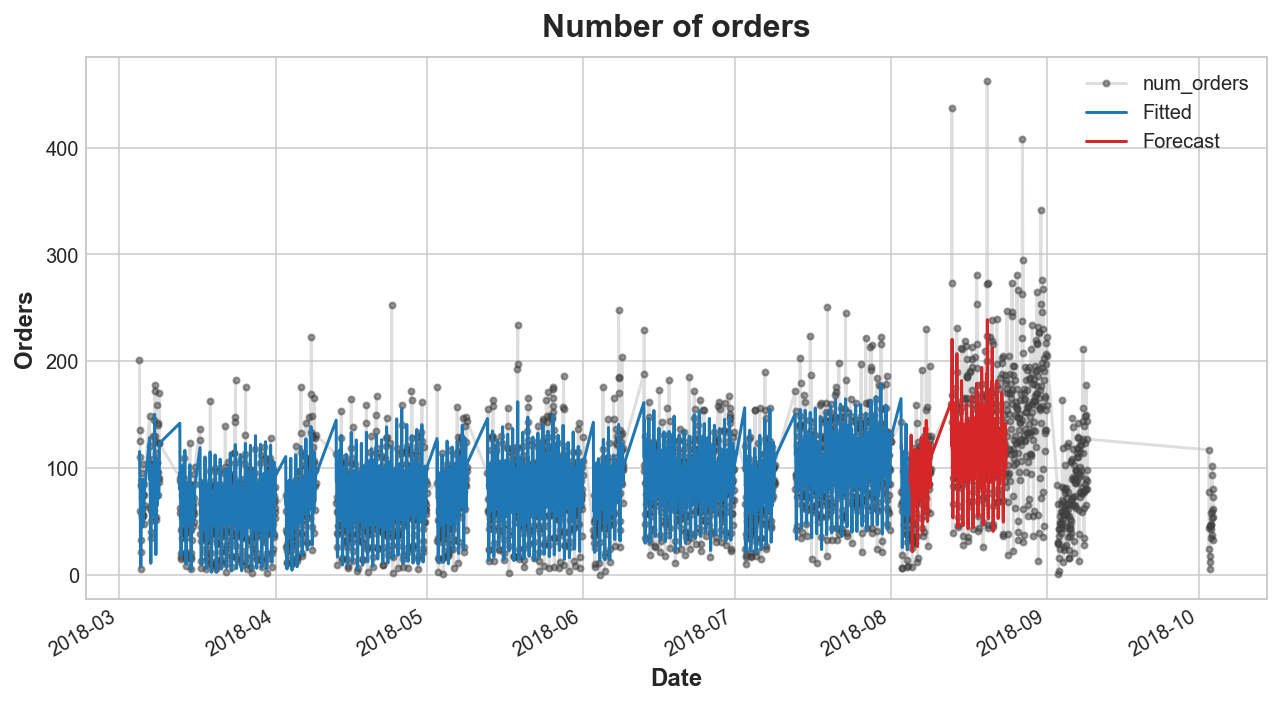

In [50]:
four = Fourier(period = 184, order = 1)
seas = Seasonality(period = 24)

dp = DeterministicProcess(
    index = d1_lt.index,
    constant = True,               # dummy feature for bias (y-intercept)
    order = 1,                     # trend (order 1 means linear)
    seasonal = False,               # monthly seasonality (indicators)
    additional_terms = [four, seas],
    drop = True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()
y = d1_lt.num_orders.copy()

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

model = LinearRegression(fit_intercept = False)
_ = model.fit(X_train, y_train)

y_fit = pd.Series(model.predict(X_train), index = y_train.index)
y_pred = pd.Series(model.predict(X_valid), index = y_valid.index)

y_deseason = pd.concat([y_train, y_valid]) - pd.concat([y_fit, y_pred])

X_lags = make_lags(y_deseason, lags = [1, 24, 48])
X = pd.concat([X_lags, X], axis=1).dropna()
y, X = y.align(X, join = 'inner')

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, shuffle = False)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, shuffle = False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index = X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index = X_valid.index).clip(0.0)

rmse_train7 = mean_squared_error(y_train, y_fit) ** 0.5
rmse_valid7 = mean_squared_error(y_valid, y_pred) ** 0.5
print(f'Training RMSE: {rmse_train7:.3f}')
print(f'Validation RMSE: {rmse_valid7:.3f}')

ax = y.plot(**plot_params, alpha=0.5, title = "Number of orders", ylabel = "Orders")
ax = y_fit.plot(ax=ax, label="Fitted", color = 'C0')
ax = y_pred.plot(ax=ax, label="Forecast", color = 'C3')
ax.legend();

# Hybrid Models

Given that we need a model that forecasts months forward, the natural next step is a hybrid model: first build a trend-based linear regression model to capture (and to forecast later) future elements and trends and then build a decision tree-based model (XGBRegressor) to capture interaction terms and seasonality. 

In [51]:
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index = X_1.index, columns = y.columns,
    )

    y_resid = y - y_fit
    y_resid = y_resid#.stack(["Month", "weekday", "Hour"]).squeeze() # wide to long

    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid

# Add method to class
BoostedHybrid.fit = fit

def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index = X_1.index, columns = self.y_columns,
    )
    #y_pred = y_pred.stack(["Month", "weekday", "Hour"]).squeeze()  # wide to long

    y_pred += self.model_2.predict(X_2).reshape(len(X_2), 1)
    
    return y_pred#.unstack(["Month", "weekday", "Hour"])  # long to wide


# Add method to class
BoostedHybrid.predict = predict

In [65]:
# Target series
y = d1_lt.num_orders

# X_1: Features for Linear Regression
dp = DeterministicProcess(index = y.index, order = 1)
X_1 = dp.in_sample()

# X_2: Features for XGBoost
X_2 = d1_lt

Choose hybrid model elements:

In [53]:
# Further model 1 candidates
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Further model 2 candidates
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

model = BoostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.07, max_depth = 7, min_child_weight = 4, n_estimators = 500, nthread = 4, objective = 'reg:squarederror', subsample = 0.7),
)

Evaluating the model performance we see slightly worse RMSE than previously with the TSC or even the Heuristics-based model.

In [54]:
y = pd.DataFrame(y)

# In the first step we will split the data in training and remaining dataset
X1_train, X1_rem, y_train, y_rem = train_test_split(X_1, y, train_size = 0.8, shuffle = False)
X1_valid, X1_test, y_valid, y_test = train_test_split(X1_rem, y_rem, test_size = 0.5, shuffle = False)

X2_train, X2_rem, y_train, y_rem = train_test_split(X_2, y, train_size = 0.8, shuffle = False)
X2_valid, X2_test, y_valid, y_test = train_test_split(X2_rem, y_rem, test_size = 0.5, shuffle = False)

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

rmse_train8 = mean_squared_error(y_train, y_fit) ** 0.5
rmse_valid8 = mean_squared_error(y_valid, y_pred) ** 0.5
print(f'Training RMSE: {rmse_train8:.5f}')
print(f'Validation RMSE: {rmse_valid8:.5f}')

Training RMSE: 3.54027
Validation RMSE: 51.46236


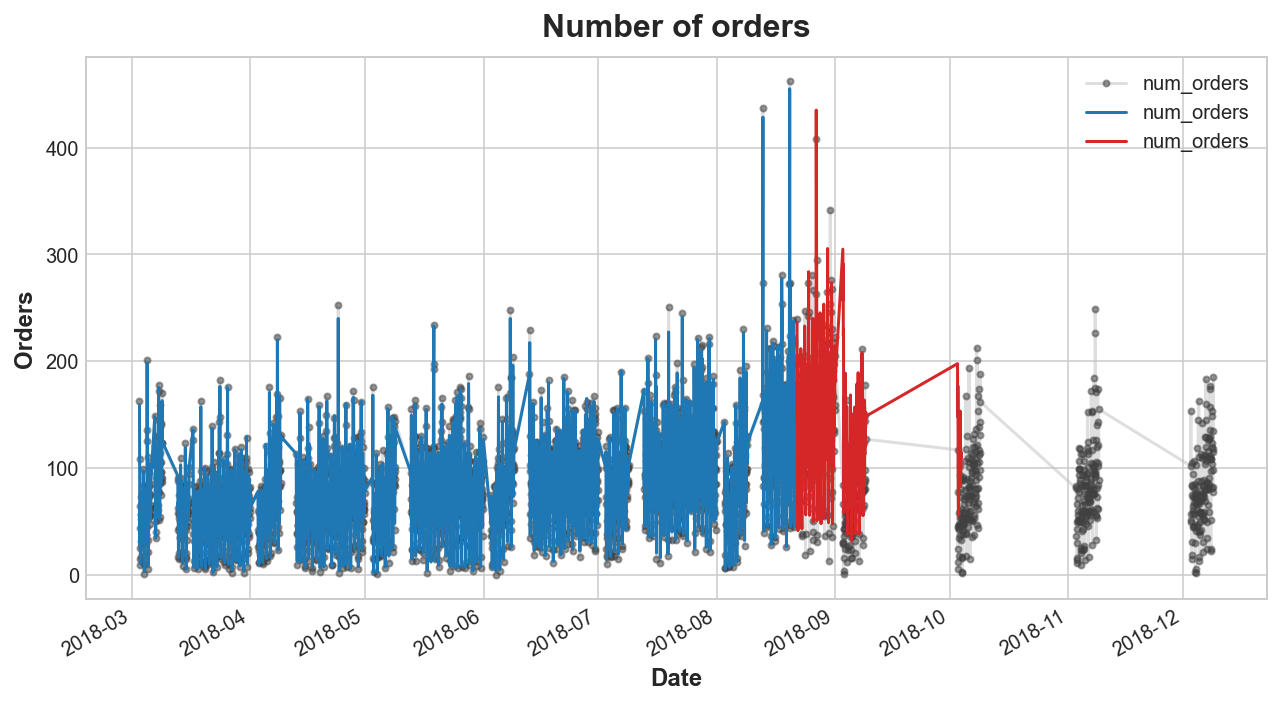

In [55]:
y_plot = y.rename(columns  = {0: "num_orders"})
y_fit_plot = y_fit.rename(columns  = {0: "Fitted"})
y_pred_plot = y_pred.rename(columns  = {0: "Predicted"})

ax = y_plot.plot(**plot_params, alpha = 0.5, title = "Number of orders", ylabel = "Orders")
ax = y_fit_plot.plot(ax = ax, label = "Fitted", color = 'C0')
ax = y_pred_plot.plot(ax = ax, label = "Forecast", color = 'C3');

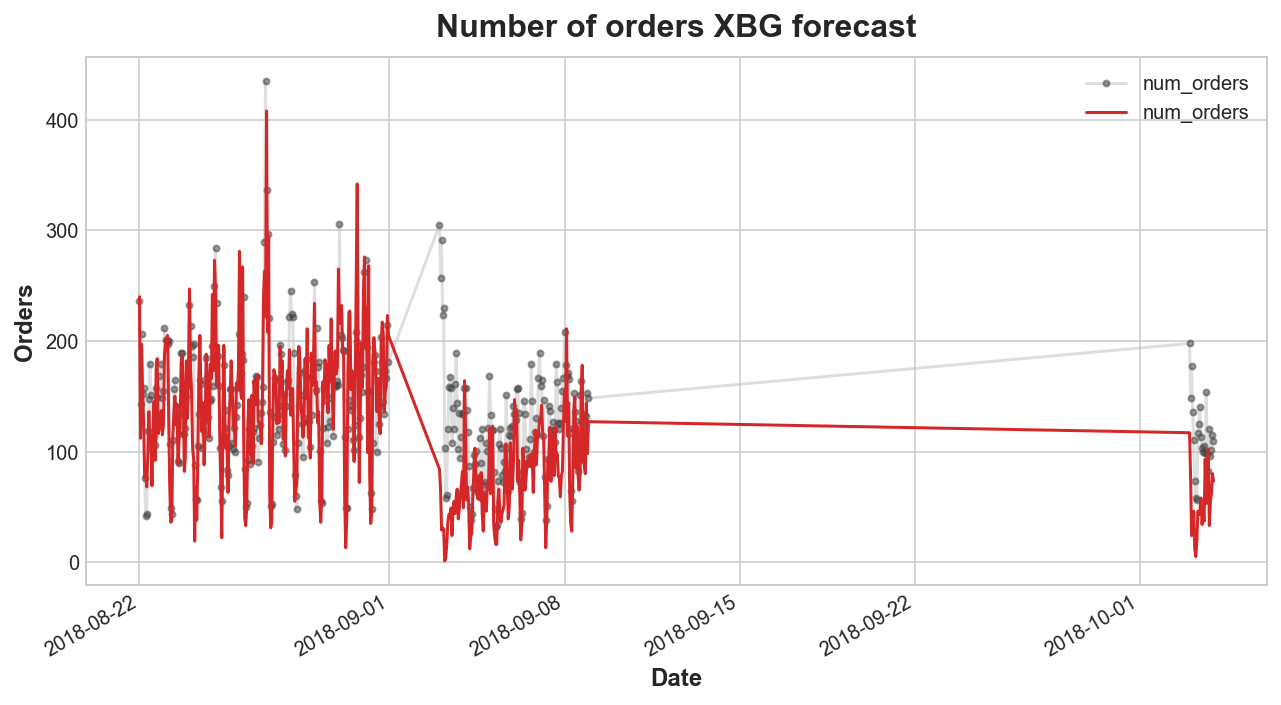

In [56]:
ax = y_pred_plot.plot(**plot_params, alpha = 0.5, title = "Number of orders XBG forecast", ylabel = "Orders")
ax = y_valid.plot(ax = ax, label = "Forecast", color = 'C3');

# SARIMAX

Lastly, explore the power of SARIMAX type model architecture. The key downside of the model is the poor prediction moving forward, nevertheless one can examine the model to find patterns as well as analyse the output.

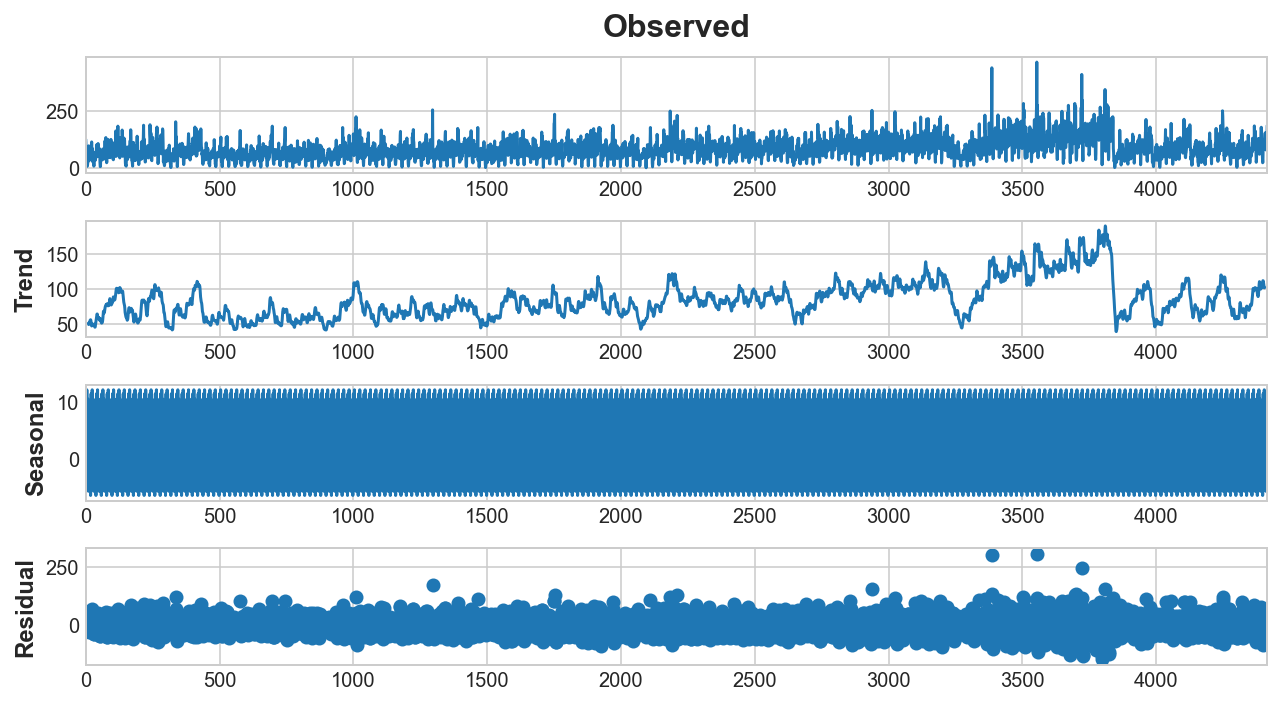

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = pd.DataFrame(data = d1.num_orders.values, index = pd.to_datetime(d1.index)).dropna()
result = seasonal_decompose(series.values, model = 'additive', period = 20)
result.plot()
plt.show()

By running a KPSS test we see that the once differenced dataset is indeed stationary. 

In [58]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

vals = d1.num_orders.diff().dropna()
vals = vals - vals.mean()

results = kpss(vals)

print(f"KPSS Statistic: {results[0]}")
print(f"p-value: {results[1]}")
print("Critical Values:")
for key, value in results[3].items():
    print("\t%s: %.3f" % (key, value))

KPSS Statistic: 0.06241278464773014
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\pohlp\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Through our previous analysis and using grid search find the SARIMAX model best suited for the exercise to be the AR(1, 24, 48), I(1), MA(3) model. 

In [59]:
import statsmodels.api as sm

X = d1.num_orders

mod = sm.tsa.SARIMAX(X, order=([1, 24, 48], 1, 3), trend='c')
res = mod.fit() 
sim = res.simulate(5, anchor='end', repetitions=10)

C:\Users\pohlp\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pohlp\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pohlp\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\pohlp\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


We can see that all the elements of the model itself have extremely low p-values: very unlikely that any of them were redundant.

In [60]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:                     num_orders   No. Observations:                 4416
Model:             SARIMAX([1, 24, 48], 1, 3)   Log Likelihood              -21459.079
Date:                        Sun, 01 May 2022   AIC                          42934.158
Time:                                23:53:48   BIC                          42985.300
Sample:                                     0   HQIC                         42952.196
                                       - 4416                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0338      0.145      0.232      0.816      -0.251       0.319
ar.L1          0.2551      0.031      8.134      0.000       0.194       0.317
ar.L24         0.2127      0.012     17.721      0.000       0.189       0.236
ar.L48         0.2230      0.014     15.856      0.000       0.195       0.251
ma.L1         -0.6798      0.034    -20.147      0.000      -0.746      -0.614
ma.L2          0.0477      0.019      2.516      0.012       0.011       0.085
ma.L3         -0.1035      0.014     -7.362      0.000      -0.131      -0.076
sigma2      1067.9687     16.051     66.535      0.000    1036.509    1099.429
===================================================================================
Ljung-Box (L1) (Q):                 133.16   Jarque-Bera (JB):              2221.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The fitted model performance is fairly comparable to the other model approaches.

In [61]:
# Generate predictions
preds = res.fittedvalues

rmse11 = mean_squared_error(preds, d1.num_orders)**0.5
print(f"The total training RMSE is: {rmse11:.3f}")

The total training RMSE is: 31.211
